In [93]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xesmf as xe
import pandas as pd
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid
import warnings
import cmocean
from matplotlib.colors import TwoSlopeNorm
from matplotlib import patheffects
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeat
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xesmf as xe
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import warnings
import matplotlib.projections
import wrf
import scipy.stats as stats
from geopy import distance
import gsw_xarray as gsw
import time
import matplotlib.path as mpath
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

#ignore by message
warnings.filterwarnings("ignore")


In [94]:
mld=xr.open_dataset('Submission/MLD_Naik_etal.nc')
topo=xr.open_dataset('Topography&Bathymetry_Naik_etal_2024PA005055.nc')
mld_pi=xr.open_dataset('MLD_PI_Naik_etal.nc')
sss=xr.open_dataset('Salinity_Naik_etal_2024PA005055.nc')
moc_ccsm3f=xr.open_dataset('Submission/MOC_CCSM3_F.nc')
moc_ccsm3h=xr.open_dataset('Submission/MOC_CCSM3_H.nc')
moc_ccsm4=xr.open_dataset('Submission/MOC_CCSM4.nc')
moc_cesm1=xr.open_dataset('Submission/MOC_CESM1.nc')
moc_ipsl=xr.open_dataset('Submission/MOC_IPSLCM5.nc')
moc_ipslt=xr.open_dataset('Submission/MOC_IPSLCM5_T.nc')
moc_hadcmb1=xr.open_dataset('Submission/MOC_HadCM3L_B1.nc')
moc_hadcmb2=xr.open_dataset('Submission/MOC_HadCM3L_B2.nc')
moc_hadcmf1=xr.open_dataset('Submission/MOC_HadCM3L_F1.nc')
moc_hadcmf2=xr.open_dataset('Submission/MOC_HadCM3L_F2.nc')
moc_hadcmf3=xr.open_dataset('Submission/MOC_HadCM3L_F3.nc')
moc_hadcml1=xr.open_dataset('Submission/MOC_HadCM3L_L1.nc')
moc_cosmos=xr.open_dataset('Submission/MOC_COSMOS.nc')
moc_giss=xr.open_dataset('Submission/MOC_GISS.nc')


moc_strength=pd.read_excel('Submission/Naik_etal_Figures.xlsx', sheet_name='MOC Strength') #strength of AMOC, PMOC and SOMOC in Miocene and PI
fwf=pd.read_excel('Submission/Naik_etal_Figures.xlsx', sheet_name='Surface FWF') #Surface freshwater flux over North Atlantic and North Pacific
salinity=pd.read_excel('Submission/Naik_etal_Figures.xlsx', sheet_name='Salinity') # Average upper salinity of North Atlantic and North Pacific (>10°N & <500m)
rmtp=pd.read_excel('Submission/Naik_etal_Figures.xlsx', sheet_name='Orography') #Height of Rocky Mountain and Tibetan Plateau
vt=pd.read_excel('Submission/Naik_etal_Figures.xlsx', sheet_name='Zonal_VT') #zonal volume transport across Panama and Tethys Seaways
ages=pd.read_excel('Submission/Naik_etal_Figures.xlsx', sheet_name='Estimated_Ages') #Calculated estimated ages and ages provided by the model simulation



In [100]:
moc_ccsm3f

<xarray.Dataset>
Dimensions:   (depth: 40, lat: 384)
Coordinates:
  * depth     (depth) float32 500.6 1.507e+03 2.528e+03 ... 5.125e+05 5.375e+05
  * lat       (lat) float32 -87.21 -86.85 -86.5 -86.14 ... 73.98 73.91 73.84
Data variables:
    GMOC_Mio  (depth, lat) float32 ...
    AMOC_Mio  (depth, lat) float32 ...
    PMOC_Mio  (depth, lat) float32 ...
    GMOC_pi   (depth, lat) float32 ...
    AMOC_pi   (depth, lat) float32 ...
    PMOC_pi   (depth, lat) float32 ...

## Functions

In [88]:
# To create gridlines on maps

font='Arial'
def gline(ax,t=False,b=False,l=False,r=False, xl=True, yl=True, tick_size=14):   
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.3, linestyle=':', draw_labels=False)
    gl.xlabels_top = t
    gl.ylabels_left = l
    gl.ylabels_right=r
    gl.xlabels_bottom = b
    gl.xlines = xl
    gl.ylines = yl
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'weight': 'light','family':font, 'size': tick_size}
    gl.ylabel_style = {'weight': 'light','family':font, 'size': tick_size}

#To create cmap diverging at 0

def truncate_colormap(cmap, minval, maxval, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# create shifted cmap for MOC plots since positive and negative stream functions are not balanced
def shiftedColorMap1(cmap, min_val, max_val,a,b, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = a, b
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap


### Figure 1 - Topography and Bathymetry

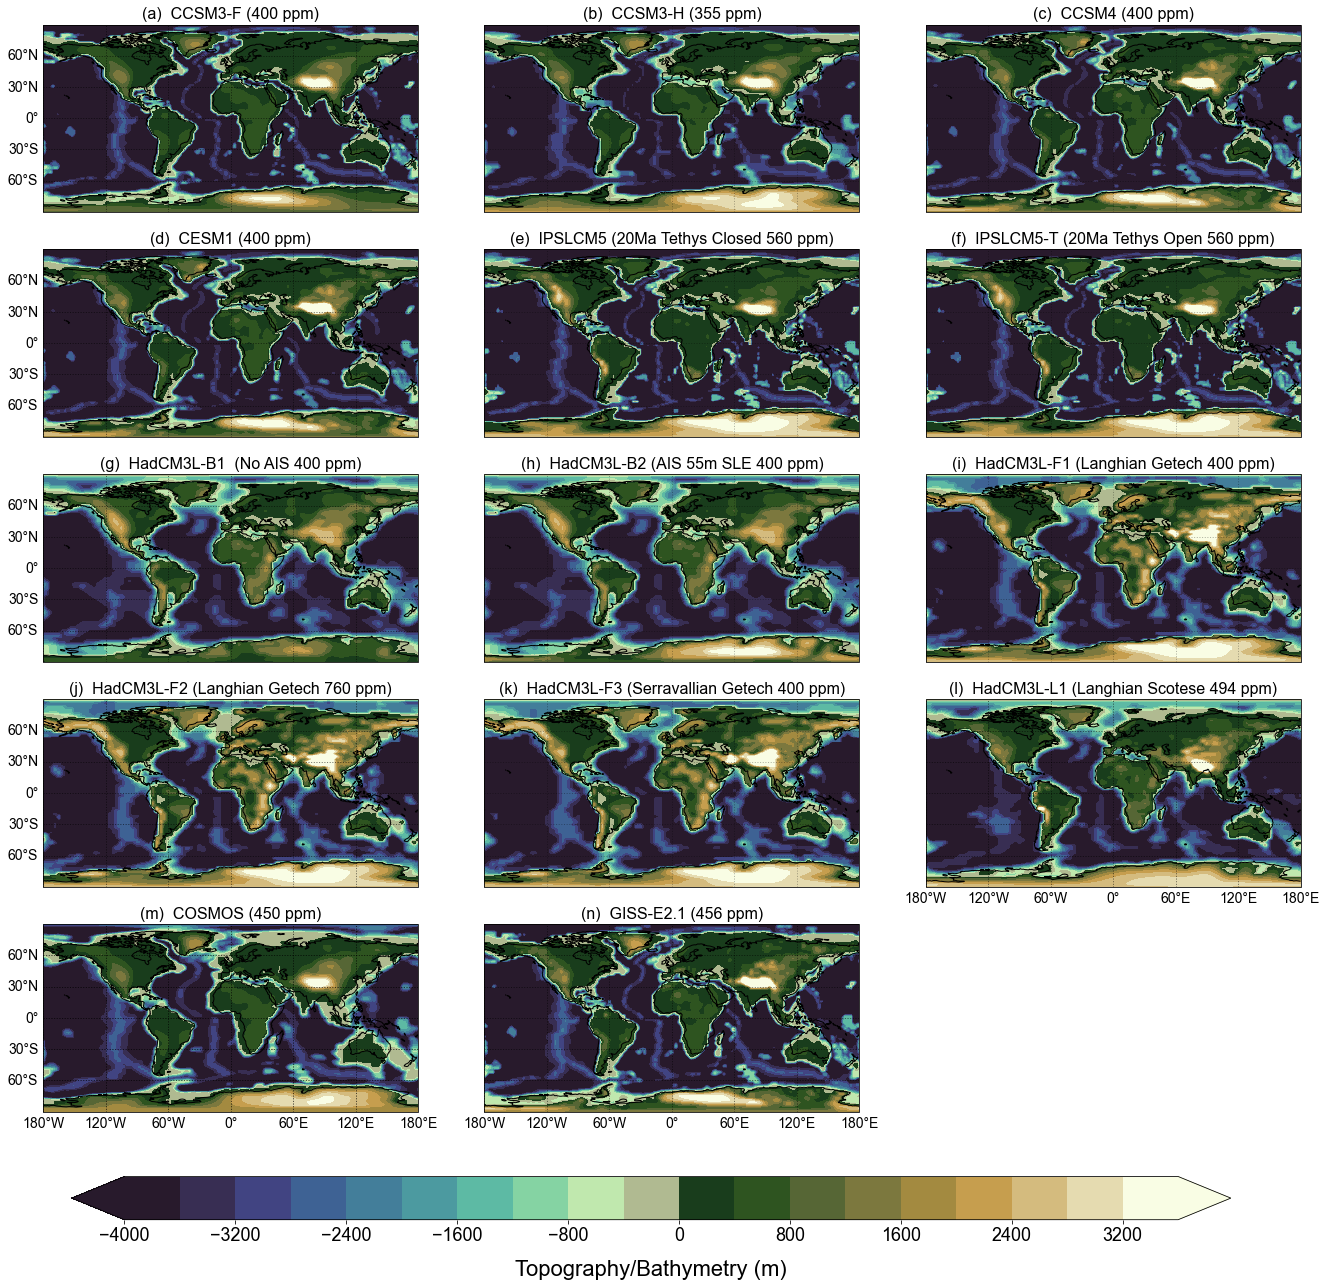

In [90]:
font='Arial'
plt.rc('font', family=font)
levels=np.arange(-4000,4000,400)
f=20;
projection=ccrs.PlateCarree(0)#Robinson(0)
cmap = plt.get_cmap('cmo.topo') # cmocean.cm.delta# #
new_cmap = truncate_colormap(cmap, 0, 1.0)
cmap.set_under(color='k')
norm = BoundaryNorm(levels, ncolors=cmap.N)
facecolour='white';alpha=0.8
pad=10
ls=np.array(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)'])
combined_titles_mio = [f"{a1} {a2}" for a1, a2 in zip(ls, mld.simulation.values)]

topo_bathy = [topo.CCSM3_F, 
        topo.CCSM3_H,
        topo.CCSM4,
        topo.CESM1,
        topo.IPSLCM5,
        topo.IPSLCM5_T,
        topo.HadCM3L_B1,
        topo.HadCM3L_B2,
        topo.HadCM3L_F1,
        topo.HadCM3L_F2,
        topo.HadCM3L_F3,
        topo.HadCM3L_L1,
        topo.COSMOS,
        topo.GISS
       ]
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,20), subplot_kw={'projection': projection}, constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  
    ax = axes[i]
    sim_data = topo_bathy[i]  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(sim_data.lon, sim_data.lat, sim_data, cmap=new_cmap, norm=norm, levels=levels, transform=ccrs.PlateCarree(0), extend='both')
    contours.append(contour)

    # Add a title for each panel
    ax.set_title(combined_titles_mio[i], fontsize=16) # mld file contains names of simulations
    
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        gline(ax,b=False,l=True)     #b=bottom ticks; l=left ticks
    if i in bottom_ticks:
        gline(ax, b=True, l=False)
    gline(ax,b=False,l=False)        #adds grid lines to rest of the plots
    
    # Add labels for axes
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Add modern coastlines
    ax.coastlines()
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('Topography/Bathymetry (m)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)

#plt.savefig('Miocene_Topography.png',dpi=300,bbox_inches='tight', transparent=False)

### Figure 2 - Mixed Layer Depths (MLD)

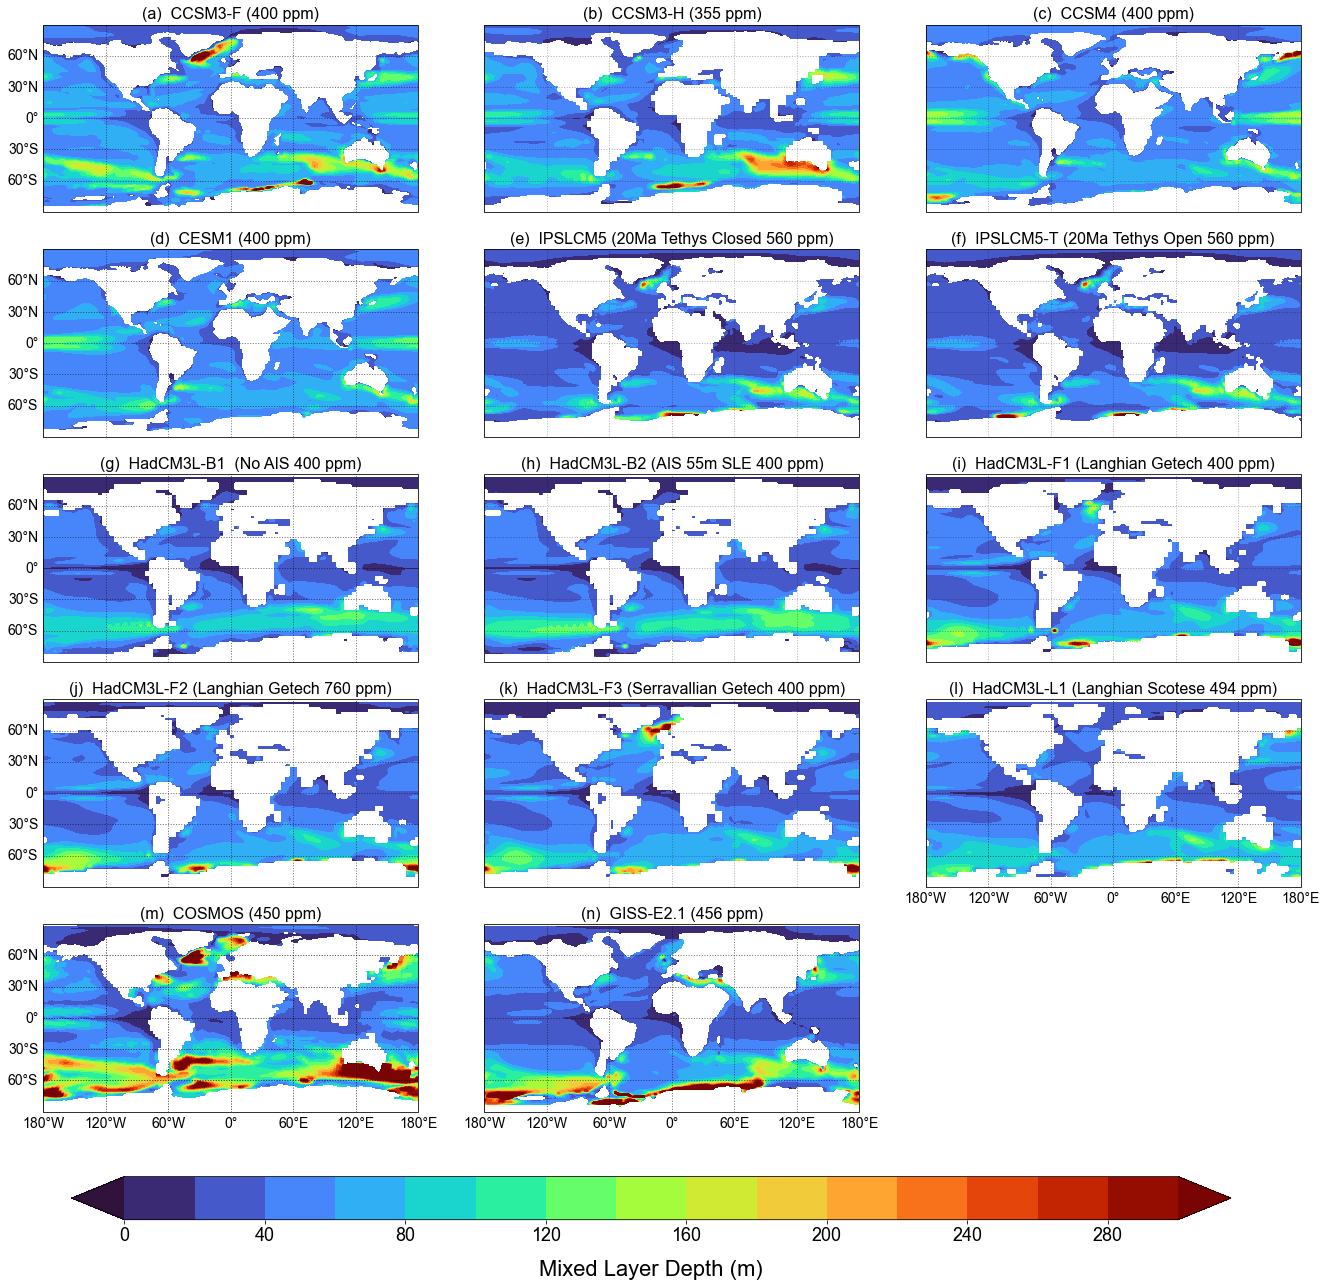

In [91]:
font='Arial'
plt.rc('font', family=font)
level=np.arange(0,320,20)
f=20;
projection=ccrs.PlateCarree(0)#Robinson(0)
cmap='turbo' #'Blues'#cmocean.cm.deep
facecolour='white';alpha=0.8
pad=10

mldi = mld['MLD'] 
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,20), subplot_kw={'projection': projection}, constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  # Adjust if the number of simulations changes
    ax = axes[i]
    sim_data = mldi.isel(sim=i)  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(sim_data.lon, sim_data.lat, sim_data, cmap=cmap, levels=level, transform=ccrs.PlateCarree(0), extend='both')
    contours.append(contour)

    # Add a title for each panel
    ax.set_title(combined_titles_mio[i], fontsize=16)
    
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        gline(ax,b=False,l=True)     #b=bottom ticks; l=left ticks
    if i in bottom_ticks:
        gline(ax, b=True, l=False)
    gline(ax,b=False,l=False)        #adds grid lines to rest of the plots
    
    # Add labels for axes
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # Customize tick visibility
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('Mixed Layer Depth (m)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)

### Figure 3 - Miocene Global Meridional Overturning Circulation (GMOC)

Text(0.515, 0.92, 'Global MOC (GMOC)')

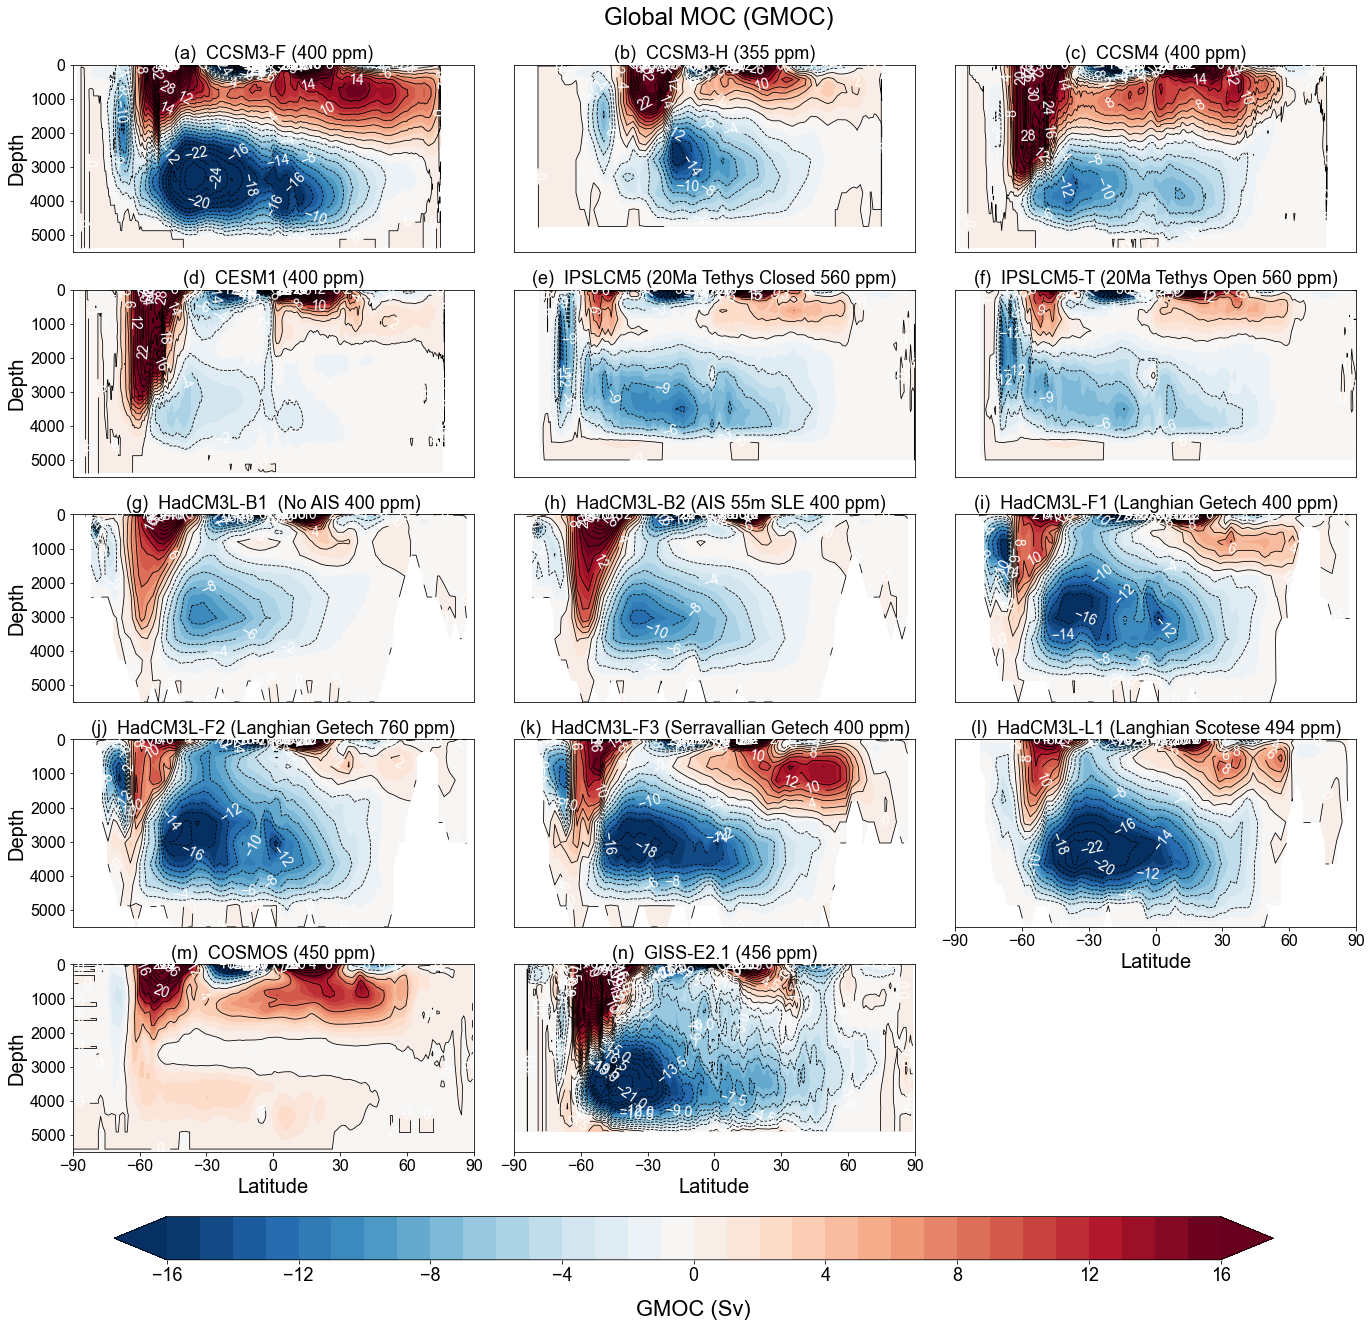

In [92]:
font='Arial'
plt.rc('font', family=font)
orig_cmap = matplotlib.cm.RdBu_r
f=20
f1=20
ts=16
cls=14 #contour label size
tl=6 #tick length
tw=2 #tick width
clev=50 #contour levels
m1=-16;m2=17;start=0.0;stop=1.0 #for shrunk_cmap
shrunk_cmap = shiftedColorMap1(orig_cmap, m1, m2,start,stop,'shrunk')
pad=10

gmoc_mio = [moc_ccsm3f.GMOC_Mio, 
              moc_ccsm3h.GMOC_Mio,
              moc_ccsm4.GMOC_Mio,
              moc_cesm1.GMOC_Mio,
              moc_ipsl.GMOC_Mio,
              moc_ipslt.GMOC_Mio,
              moc_hadcmb1.GMOC_Mio,
              moc_hadcmb2.GMOC_Mio,
              moc_hadcmf1.GMOC_Mio,
              moc_hadcmf2.GMOC_Mio,
              moc_hadcmf3.GMOC_Mio,
              moc_hadcml1.GMOC_Mio,
              moc_cosmos.GMOC_Mio,
              moc_giss.GMOC_Mio
       ]

gmoc_mio_lat = [moc_ccsm3f.lat, 
              moc_ccsm3h.lat,
              moc_ccsm4.lat,
              moc_cesm1.lat,
              moc_ipsl.y,
              moc_ipslt.y,
              moc_hadcmb1.latitude,
              moc_hadcmb2.latitude,
              moc_hadcmf1.latitude,
              moc_hadcmf2.latitude,
              moc_hadcmf3.latitude,
              moc_hadcml1.latitude,
              moc_cosmos.lat,
              moc_giss.lat
       ]
gmoc_mio_depth = [moc_ccsm3f.depth/100, 
              moc_ccsm3h.depth/100,
              moc_ccsm4.depth/100,
              moc_cesm1.depth/100,
              moc_ipsl.depthw,
              moc_ipslt.depthw,
              moc_hadcmb1.depth,
              moc_hadcmb2.depth,
              moc_hadcmf1.depth,
              moc_hadcmf2.depth,
              moc_hadcmf3.depth,
              moc_hadcml1.depth,
              moc_cosmos.lev,
              moc_giss.depth
       ]
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,20), constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  
    ax = axes[i]
    sim_data = gmoc_mio[i]  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(gmoc_mio_lat[i], gmoc_mio_depth[i], sim_data, cmap=shrunk_cmap,levels=np.arange(m1,m2,1),extend='both')
    contours.append(contour)
    MOC1=ax.contour(gmoc_mio_lat[i], gmoc_mio_depth[i], sim_data,levels=clev, linewidths=0.8, colors='k')
    ax.clabel(MOC1, inline=1, fontsize=cls,colors='w',rightside_up=True)

    # Add a title for each panel
    ax.set_title(combined_titles_mio[i], fontsize=18) # mld file contains names of simulations
    ax.axis([-89.5,89.5,5500,0])
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        ax.set_yticks(np.arange(5000, -1, -1000))

        ax.set_ylabel("Depth", fontsize=f1)
    else:
        ax.set_yticks([])
    if i in bottom_ticks:
        ax.set_xticks(np.arange(-90, 91, 30))       #adds grid lines to rest of the plots
        ax.set_xlabel("Latitude", fontsize=f1) 
    else:
        ax.set_xticks([])
    # Add labels for axes
    
    ax.tick_params(labelsize=ts)
    
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('GMOC (Sv)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('Global MOC (GMOC)',x=0.515,y=0.92, fontsize=24)

#plt.savefig('Miocene_GMOC.png',dpi=300,bbox_inches='tight', transparent=False)

### Figure 4 - MOC strengths: Miocene vs. PI 

In [8]:
moc_strength

Simulations  AMOC_Miocene    AMOC_PI  PMOC_Miocene   PMOC_PI  \
0       CCSM3_F     14.210000  16.020000      0.970000  3.830000   
1       CCSM3_H      5.550000  15.125931      1.410610  4.975703   
2         CCSM4      6.550000  24.488998      6.913148  1.443591   
3         CESM1      4.900000  24.287232      0.666028  1.742230   
4       IPSLCM5      6.991843  11.139221      0.055876  1.700836   
5     IPSLCM5_T      8.787570  11.139221      0.036233  1.700836   
6    HadCM3L_B1      1.940160  16.273062      1.101752  0.383954   
7   HadCM3L_B2       1.254420  16.273062      1.020240  0.383954   
8    HadCM3L_F1      8.109295  19.441463      1.020111  0.861318   
9    HadCM3L_F2      4.261272  19.441463      1.073292  0.861318   
10   HadCM3L_F3     15.672021  19.441463      1.021690  0.861318   
11   HadCM3L_L1      3.683608  19.441463      9.615513  0.861318   
12       COSMOS     13.110000  16.000000      5.214844  1.570000   
13         GISS      2.260000  24.240000      1.690000  0.640000   

    SOMOC_Miocene   SOMOC_PI  
0          -27.90 -21.510000  
1          -17.80 -14.993000  
2          -13.00  -8.460544  
3           -6.00  -5.568787  
4          -16.60 -16.123137  
5          -14.60 -16.123137  
6          -11.10 -16.693449  
7          -13.00 -16.693449  
8          -17.50 -20.327190  
9          -18.70 -20.327190  
10         -19.70 -20.327190  
11         -23.10 -20.327190  
12          -3.30  -8.660000  
13         -26.71 -10.980000

Text(0.5, 0, 'Miocene SOMOC Strength (Sv) ')

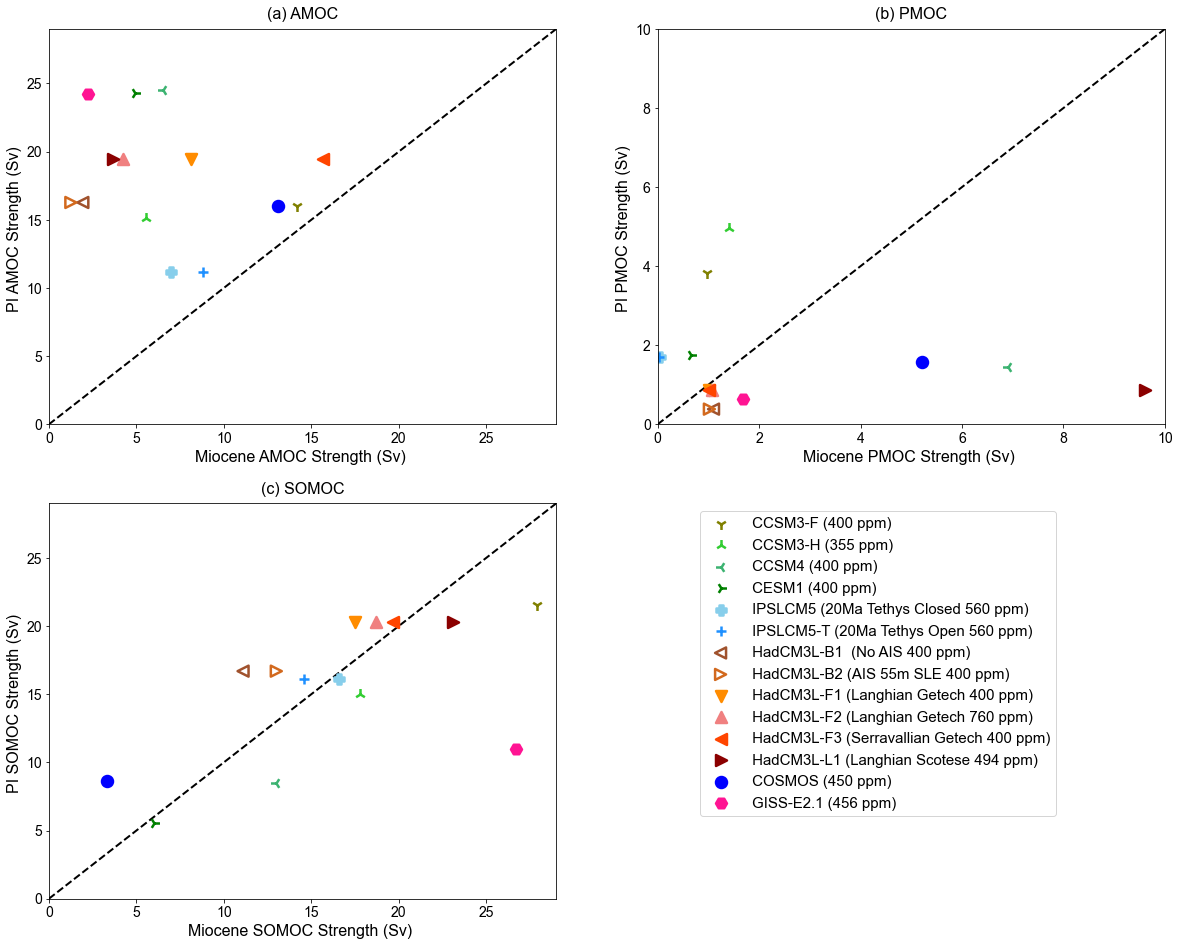

In [9]:
amoc_mio = moc_strength['AMOC_Miocene'].to_numpy()
amoc_pi = moc_strength['AMOC_PI'].to_numpy()
pmoc_mio = moc_strength['PMOC_Miocene'].to_numpy()
pmoc_pi = moc_strength['PMOC_PI'].to_numpy()
somoc_mio = moc_strength['SOMOC_Miocene'].to_numpy()
somoc_pi = moc_strength['SOMOC_PI'].to_numpy()
labels_short = moc_strength['Simulations'].to_list()
labels=[' CCSM3-F (400 ppm)',' CCSM3-H (355 ppm)',' CCSM4 (400 ppm)',' CESM1 (400 ppm)',' IPSLCM5 (20Ma Tethys Closed 560 ppm)',
        ' IPSLCM5-T (20Ma Tethys Open 560 ppm)',' HadCM3L-B1  (No AIS 400 ppm)',' HadCM3L-B2 (AIS 55m SLE 400 ppm)',
        ' HadCM3L-F1 (Langhian Getech 400 ppm)',' HadCM3L-F2 (Langhian Getech 760 ppm)',' HadCM3L-F3 (Serravallian Getech 400 ppm)',
        ' HadCM3L-L1 (Langhian Scotese 494 ppm)',' COSMOS (450 ppm)',' GISS-E2.1 (456 ppm)']


markers=['1','2','3','4','P','+','<','>','v','^','<','>','o','H']
edgecolors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','sienna','chocolate','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']
facecolors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','none','none','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']

mlw=2.5
f=16
f1=14
s=120
plt.figure(figsize=[20,16])



plt.subplot(221)
style='steps-mid'
for i in range(14):
    plt.scatter(amoc_mio[i],amoc_pi[i],s=s,marker=markers[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,label=labels[i],zorder=1)   
plt.axline((0, 0), (1, 1), linewidth=2, color='k', ls='--',zorder=0)

plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.xlim(0,29)
plt.ylim(0,29)
plt.title('(a) AMOC',fontsize=f, pad=10)
plt.ylabel('PI AMOC Strength (Sv) ',fontsize=f)#(magnitude)
plt.xlabel('Miocene AMOC Strength (Sv) ',fontsize=f)#(magnitude)


plt.subplot(222)
style='steps-mid'
for i in range(14):
    plt.scatter(pmoc_mio[i],pmoc_pi[i],s=s,marker=markers[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,label=labels[i],zorder=1)   
plt.axline((0, 0), (1, 1), linewidth=2, color='k', ls='--',zorder=0)

plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('(b) PMOC',fontsize=f, pad=10)
plt.ylabel('PI PMOC Strength (Sv) ',fontsize=f)#(magnitude)
plt.xlabel('Miocene PMOC Strength (Sv) ',fontsize=f)#(magnitude)

plt.subplot(223)
style='steps-mid'
for i in range(14):
    plt.scatter(abs(somoc_mio[i]),abs(somoc_pi[i]),s=s,marker=markers[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,label=labels[i],zorder=1)   
plt.axline((0, 0), (1, 1), linewidth=2, color='k', ls='--',zorder=0)

plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.xlim(0,29)
plt.ylim(0,29)
plt.title('(c) SOMOC',fontsize=f, pad=10)
plt.legend(fontsize=15, bbox_to_anchor=(2.0, 1))
plt.ylabel('PI SOMOC Strength (Sv) ',fontsize=f)#(magnitude)
plt.xlabel('Miocene SOMOC Strength (Sv) ',fontsize=f)#(magnitude)

#plt.tight_layout()

### Figure 5 - AMOC Miocene

Text(0.515, 0.92, 'Atlantic MOC (AMOC)')

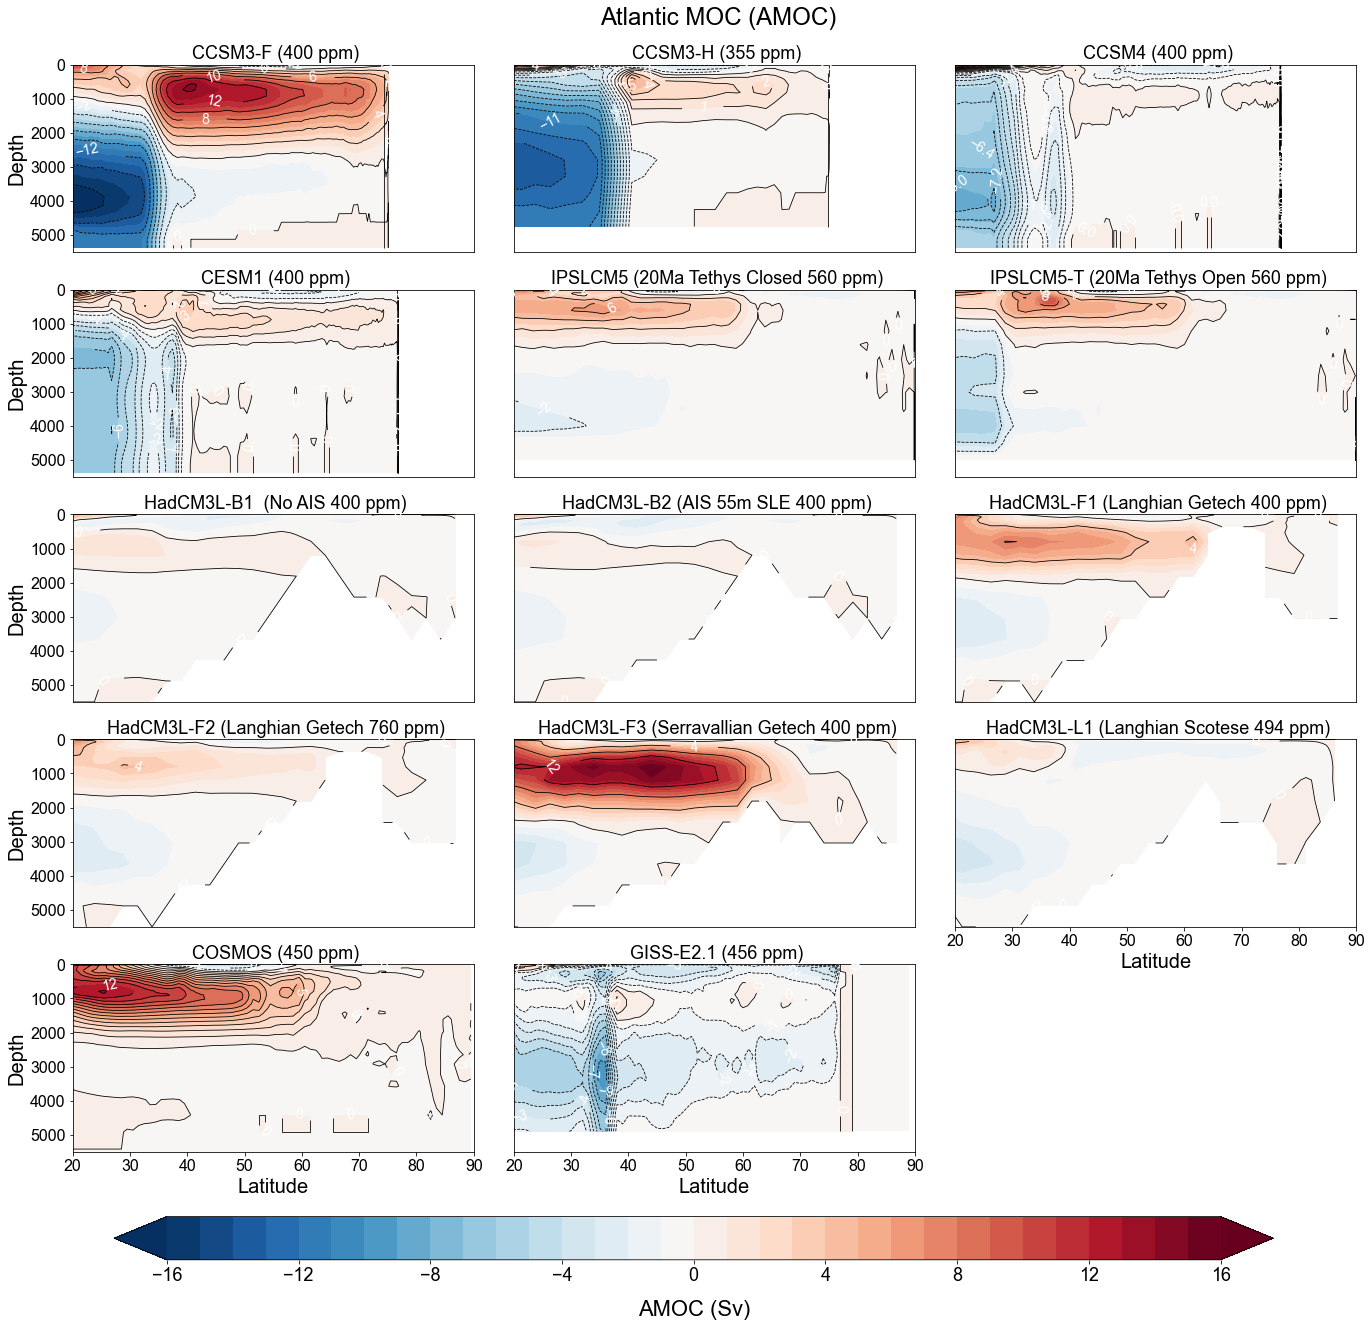

In [57]:
font='Arial'
plt.rc('font', family=font)
orig_cmap = matplotlib.cm.RdBu_r
f=20
f1=20
ts=16
cls=14 #contour label size
tl=6 #tick length
tw=2 #tick width
clev=25 #contour levels
m1=-16;m2=17;start=0.0;stop=1.0 #for shrunk_cmap
shrunk_cmap = shiftedColorMap1(orig_cmap, m1, m2,start,stop,'shrunk')
pad=10

amoc_mio = [moc_ccsm3f.AMOC_Mio, 
              moc_ccsm3h.AMOC_Mio,
              moc_ccsm4.AMOC_Mio,
              moc_cesm1.AMOC_Mio,
              moc_ipsl.AMOC_Mio,
              moc_ipslt.AMOC_Mio,
              moc_hadcmb1.AMOC_Mio,
              moc_hadcmb2.AMOC_Mio,
              moc_hadcmf1.AMOC_Mio,
              moc_hadcmf2.AMOC_Mio,
              moc_hadcmf3.AMOC_Mio,
              moc_hadcml1.AMOC_Mio,
              moc_cosmos.AMOC_Mio,
              moc_giss.AMOC_Mio
       ]

amoc_mio_lat = [moc_ccsm3f.lat, 
              moc_ccsm3h.lat,
              moc_ccsm4.lat,
              moc_cesm1.lat,
              moc_ipsl.y,
              moc_ipslt.y,
              moc_hadcmb1.latitude,
              moc_hadcmb2.latitude,
              moc_hadcmf1.latitude,
              moc_hadcmf2.latitude,
              moc_hadcmf3.latitude,
              moc_hadcml1.latitude,
              moc_cosmos.lat,
              moc_giss.lat
       ]
amoc_mio_depth = [moc_ccsm3f.depth/100, 
              moc_ccsm3h.depth/100,
              moc_ccsm4.depth/100,
              moc_cesm1.depth/100,
              moc_ipsl.depthw,
              moc_ipslt.depthw,
              moc_hadcmb1.depth,
              moc_hadcmb2.depth,
              moc_hadcmf1.depth,
              moc_hadcmf2.depth,
              moc_hadcmf3.depth,
              moc_hadcml1.depth,
              moc_cosmos.lev,
              moc_giss.depth
       ]
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,20), constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  
    ax = axes[i]
    sim_data = amoc_mio[i]  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(amoc_mio_lat[i], amoc_mio_depth[i], sim_data, cmap=shrunk_cmap,levels=np.arange(m1,m2,1),extend='both')
    contours.append(contour)
    MOC1=ax.contour(amoc_mio_lat[i], amoc_mio_depth[i], sim_data,levels=clev, linewidths=0.8, colors='k')
    ax.clabel(MOC1, inline=1, fontsize=cls,colors='w',rightside_up=True)

    # Add a title for each panel
    ax.set_title(mld.simulation[i].values, fontsize=18) # mld file contains names of simulations
    ax.axis([20,89.5,5500,0])
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        ax.set_yticks(np.arange(5000, -1, -1000))

        ax.set_ylabel("Depth", fontsize=f1)
    else:
        ax.set_yticks([])
    if i in bottom_ticks:
        ax.set_xticks(np.arange(20, 91, 10))       #adds grid lines to rest of the plots
        ax.set_xlabel("Latitude", fontsize=f1) 
    else:
        ax.set_xticks([])
    # Add labels for axes
    
    ax.tick_params(labelsize=ts)
    
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('AMOC (Sv)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('Atlantic MOC (AMOC)',x=0.515,y=0.92, fontsize=24)

#plt.savefig('Miocene_AMOC.png',dpi=300,bbox_inches='tight', transparent=False)

### Figure 6 - PMOC Miocene

Text(0.515, 0.92, 'Pacific MOC (PMOC)')

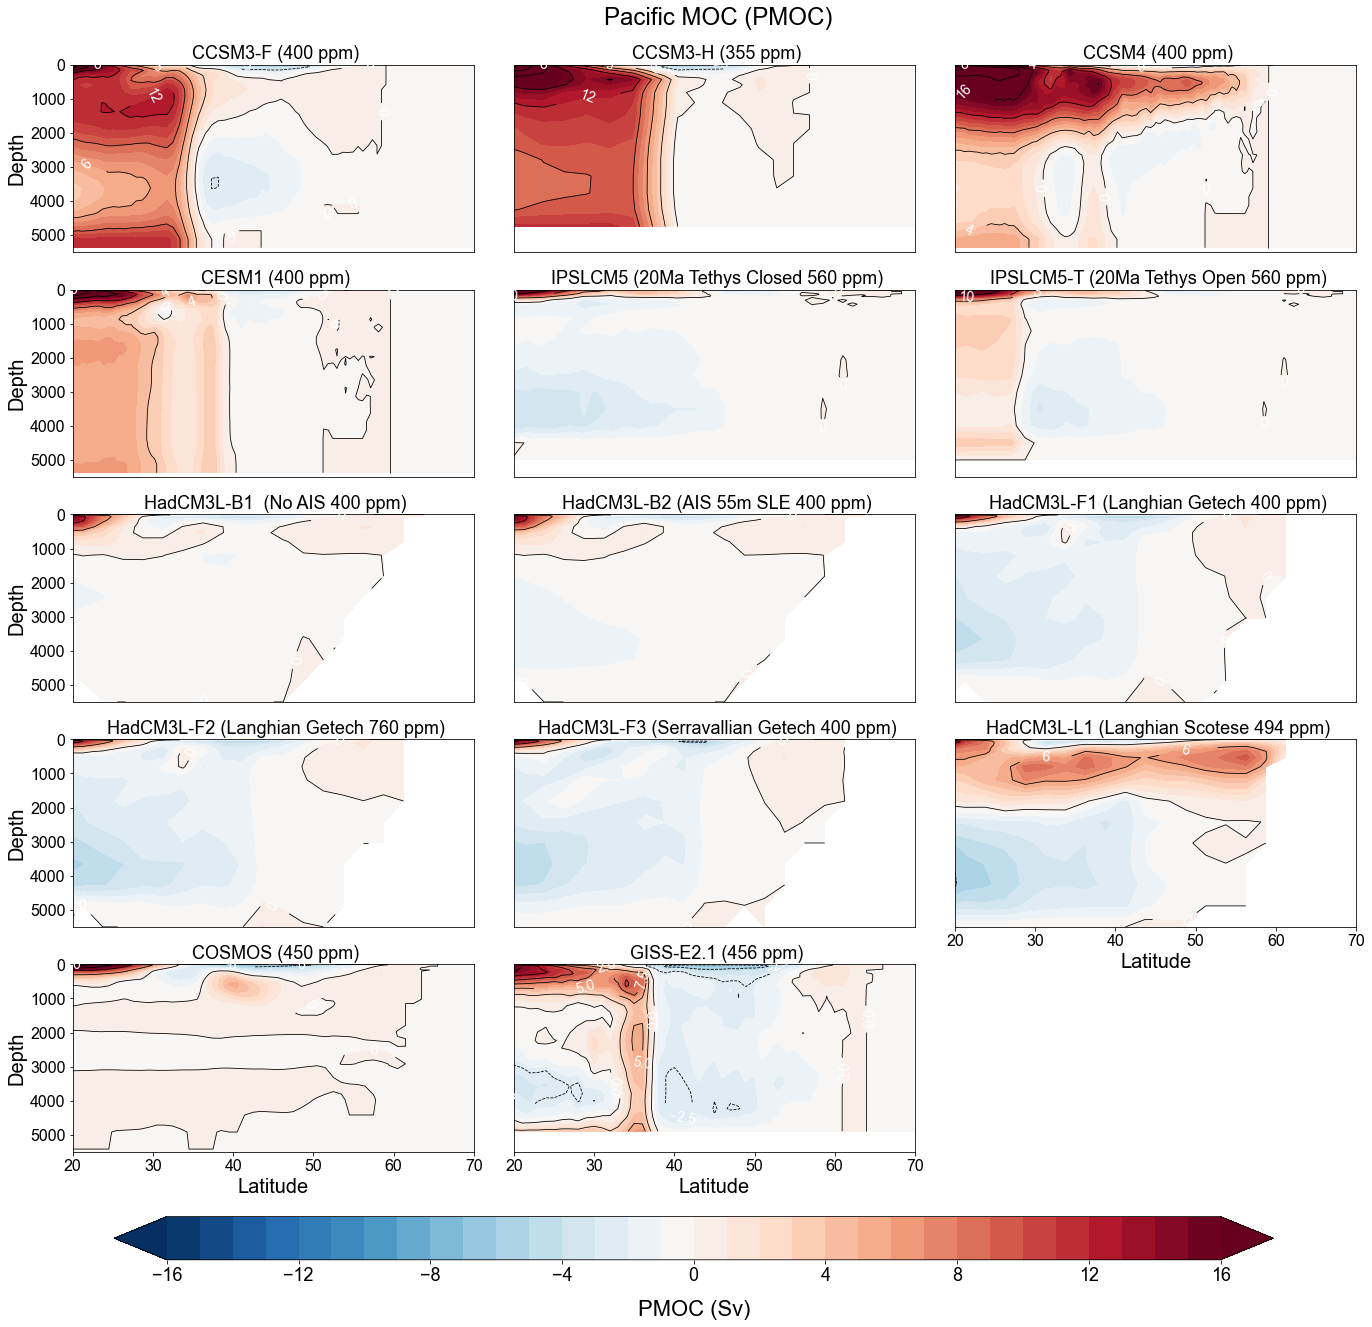

In [11]:
font='Arial'
plt.rc('font', family=font)
orig_cmap = matplotlib.cm.RdBu_r
f=20
f1=20
ts=16
cls=14 #contour label size
tl=6 #tick length
tw=2 #tick width
clev=25 #contour levels
m1=-16;m2=17;start=0.0;stop=1.0 #for shrunk_cmap
shrunk_cmap = shiftedColorMap1(orig_cmap, m1, m2,start,stop,'shrunk')
pad=10

gmoc_mio = [moc_ccsm3f.PMOC_Mio, 
              moc_ccsm3h.PMOC_Mio,
              moc_ccsm4.PMOC_Mio,
              moc_cesm1.PMOC_Mio,
              moc_ipsl.PMOC_Mio,
              moc_ipslt.PMOC_Mio,
              moc_hadcmb1.PMOC_Mio,
              moc_hadcmb2.PMOC_Mio,
              moc_hadcmf1.PMOC_Mio,
              moc_hadcmf2.PMOC_Mio,
              moc_hadcmf3.PMOC_Mio,
              moc_hadcml1.PMOC_Mio,
              moc_cosmos.PMOC_Mio,
              moc_giss.PMOC_Mio
       ]

gmoc_mio_lat = [moc_ccsm3f.lat, 
              moc_ccsm3h.lat,
              moc_ccsm4.lat,
              moc_cesm1.lat,
              moc_ipsl.y,
              moc_ipslt.y,
              moc_hadcmb1.latitude,
              moc_hadcmb2.latitude,
              moc_hadcmf1.latitude,
              moc_hadcmf2.latitude,
              moc_hadcmf3.latitude,
              moc_hadcml1.latitude,
              moc_cosmos.lat,
              moc_giss.lat
       ]
gmoc_mio_depth = [moc_ccsm3f.depth/100, 
              moc_ccsm3h.depth/100,
              moc_ccsm4.depth/100,
              moc_cesm1.depth/100,
              moc_ipsl.depthw,
              moc_ipslt.depthw,
              moc_hadcmb1.depth,
              moc_hadcmb2.depth,
              moc_hadcmf1.depth,
              moc_hadcmf2.depth,
              moc_hadcmf3.depth,
              moc_hadcml1.depth,
              moc_cosmos.lev,
              moc_giss.depth
       ]
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,20), constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  
    ax = axes[i]
    sim_data = gmoc_mio[i]  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(gmoc_mio_lat[i], gmoc_mio_depth[i], sim_data, cmap=shrunk_cmap,levels=np.arange(m1,m2,1),extend='both')
    contours.append(contour)
    MOC1=ax.contour(gmoc_mio_lat[i], gmoc_mio_depth[i], sim_data,levels=clev, linewidths=0.8, colors='k')
    ax.clabel(MOC1, inline=1, fontsize=cls,colors='w',rightside_up=True)

    # Add a title for each panel
    ax.set_title(mld.simulation[i].values, fontsize=18) # mld file contains names of simulations
    ax.axis([20,70,5500,0])
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        ax.set_yticks(np.arange(5000, -1, -1000))

        ax.set_ylabel("Depth", fontsize=f1)
    else:
        ax.set_yticks([])
    if i in bottom_ticks:
        ax.set_xticks(np.arange(20, 71, 10))       #adds grid lines to rest of the plots
        ax.set_xlabel("Latitude", fontsize=f1) 
    else:
        ax.set_xticks([])
    # Add labels for axes
    
    ax.tick_params(labelsize=ts)
    
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('PMOC (Sv)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('Pacific MOC (PMOC)',x=0.515,y=0.92, fontsize=24)

#plt.savefig('Miocene_AMOC.png',dpi=300,bbox_inches='tight', transparent=False)

### Figure 7 - Surface freshwater flux (FWF) vs AMOC/PMOC

In [33]:
fwf


Simulations  Atlantic_Surface_FWF_mio  Pacific_Surface_FWF_mio  \
0       CCSM3_F                  0.000016                 0.000023   
1       CCSM3_H                  0.000015                 0.000020   
2         CCSM4                  0.000022                 0.000015   
3         CESM1                  0.000021                 0.000022   
4       IPSLCM5                  0.000023                 0.000027   
5     IPSLCM5_T                  0.000023                 0.000027   
6    HadCM3L_B1                  0.000026                 0.000024   
7   HadCM3L_B2                   0.000026                 0.000024   
8    HadCM3L_F1                  0.000018                 0.000023   
9    HadCM3L_F2                  0.000021                 0.000025   
10   HadCM3L_F3                  0.000015                 0.000022   
11   HadCM3L_L1                  0.000020                 0.000018   
12       COSMOS                  0.000023                 0.000035   
13         GISS                  0.000017                 0.000016   

    Atlantic_Surface_FWF_PI  Pacific_Surface_FWF_PI  
0                  0.000015                0.000023  
1                  0.000016                0.000024  
2                  0.000018                0.000010  
3                  0.000011                0.000021  
4                  0.000006                0.000008  
5                  0.000006                0.000008  
6                  0.000014                0.000021  
7                  0.000014                0.000021  
8                  0.000013                0.000021  
9                  0.000013                0.000021  
10                 0.000013                0.000021  
11                 0.000013                0.000021  
12                 0.000022                0.000028  
13                 0.000018                0.000019

Text(0.2, 0.1, 'p = 0.0016')

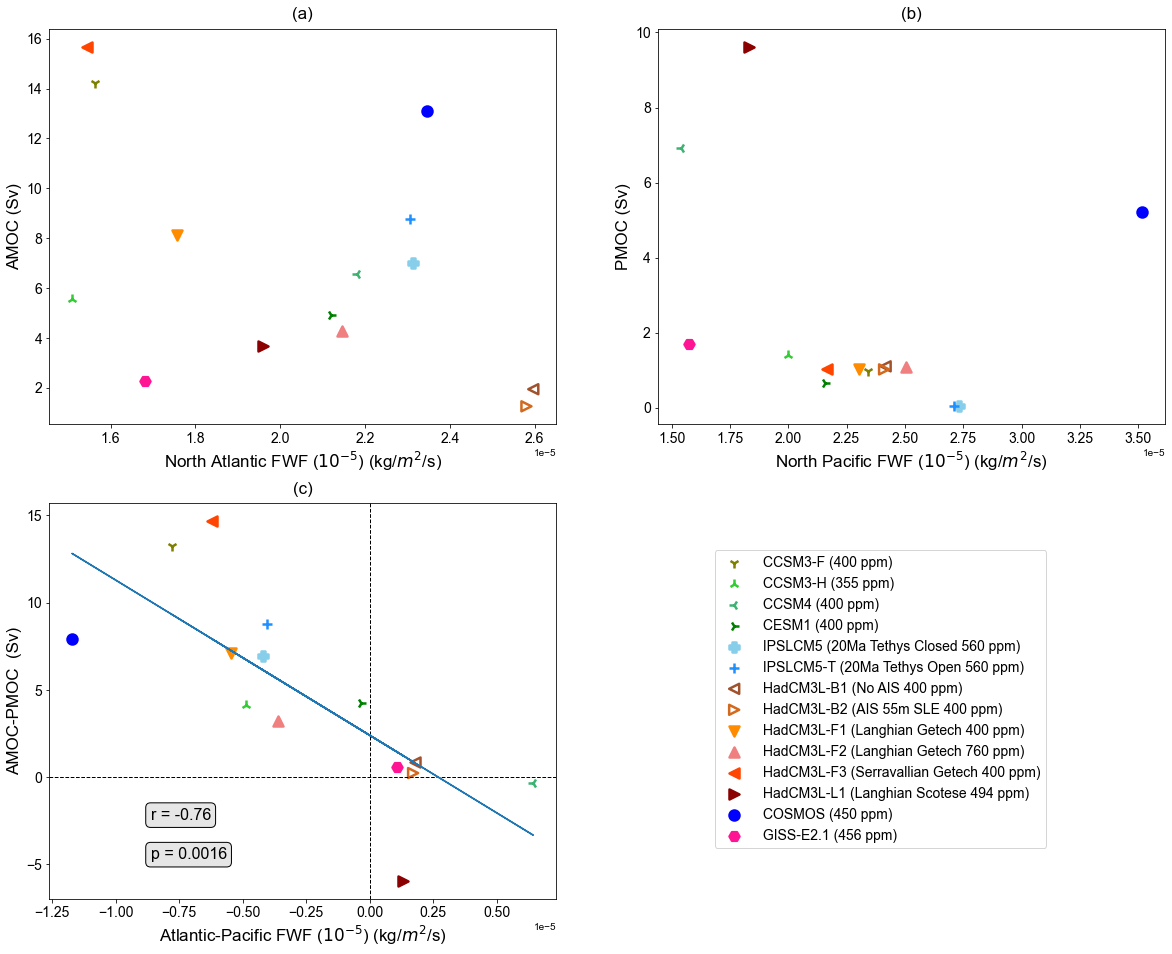

In [34]:
markers=['1','2','3','4','P','+','<','>','v','^','<','>','o','H']
edgecolors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','sienna','chocolate','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']
facecolors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','none','none','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']

fwf_atl=fwf['Atlantic_Surface_FWF_mio'].to_numpy()
fwf_pac=fwf['Pacific_Surface_FWF_mio'].to_numpy()
del_moc=amoc_mio-pmoc_mio
del_fwf=fwf_atl-fwf_pac

s=100
mlw=2.5 #marker line width
f=17
bbox = dict(boxstyle="round", fc="0.9")

plt.figure(figsize=[20,16])

plt.subplot(221)

for i in range(14):
    plt.scatter(fwf_atl[i],amoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'North Atlantic FWF ($10^{-5}$) (kg/$m^{2}$/s)',fontsize=f)
plt.ylabel(r'AMOC (Sv)',fontsize=f)

plt.title('(a)',fontsize=f, pad=10)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
#plt.ylim(0,16)

plt.subplot(222)

for i in range(14):
    plt.scatter(fwf_pac[i],pmoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'North Pacific FWF ($10^{-5}$) (kg/$m^{2}$/s)',fontsize=f)
plt.ylabel(r'PMOC (Sv)',fontsize=f)
plt.title('(b)',fontsize=f, pad=10)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)

plt.subplot(223)

for i in range(14):
    plt.scatter(del_fwf[i],del_moc[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'Atlantic-Pacific FWF ($10^{-5}$) (kg/$m^{2}$/s)',fontsize=f)
plt.ylabel(r'AMOC-PMOC  (Sv)',fontsize=f)

plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.title('(c)',fontsize=f, pad=10)
plt.legend(fontsize=f1, bbox_to_anchor=(1.98, 0.9))
m, b = np.polyfit(del_fwf, del_moc, 1)
plt.plot(del_fwf, m*(del_fwf)+b)
r, p = stats.pearsonr(del_fwf, del_moc)
plt.annotate('r = {:.2f}'.format(r), xy=(0.2,0.2), xycoords='axes fraction',fontsize=f1+2,bbox=bbox)
plt.annotate('p = {:.4f}'.format(p), xy=(0.2,0.1), xycoords='axes fraction',fontsize=f1+2,bbox=bbox)


### Figure 8 - Salinity vs AMOC/PMOC - Miocene

In [35]:
salinity

Simulations  NA_Salinity_500  NP_Salinity_500  NA_Salinity_surface  \
0       CCSM3_F        36.100708        35.181110            32.783215   
1       CCSM3_H        34.981905        34.800000            30.118030   
2         CCSM4        35.564671        35.460000            29.996266   
3         CESM1        35.687008        34.430000            31.127412   
4       IPSLCM5        36.119016        34.919826            32.553034   
5     IPSLCM5_T        36.097624        34.960045            31.506735   
6    HadCM3L_B1        35.145773        35.188506            29.292253   
7   HadCM3L_B2         35.212667        35.378029            29.514460   
8    HadCM3L_F1        35.663686        34.323625            32.263755   
9    HadCM3L_F2        35.585932        34.185697            31.087970   
10   HadCM3L_F3        35.884295        34.354378            33.480525   
11   HadCM3L_L1        35.718786        35.350389            31.763823   
12       COSMOS        36.608337        34.188977            32.421267   
13         GISS        35.700000        35.570000            32.404566   

    NP_Salinity_surface  
0             32.669167  
1             31.619568  
2             35.120374  
3             32.914522  
4             32.320727  
5             32.250670  
6             31.806852  
7             32.005170  
8             32.386215  
9             31.880225  
10            32.523839  
11            34.247195  
12            32.427487  
13            33.144766

Text(0, 0.5, 'AMOC-PMOC  (Sv)')

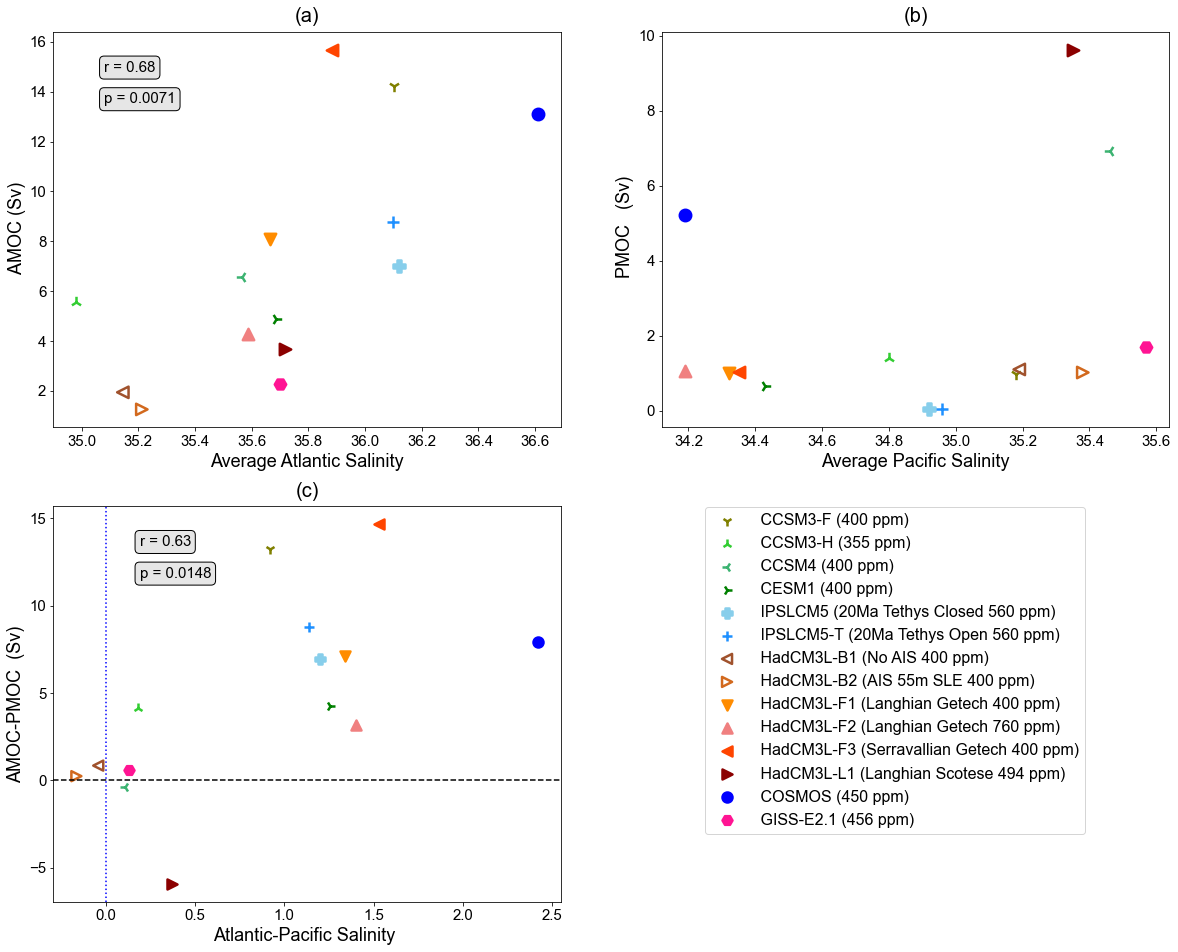

In [37]:
plt.figure(figsize=[20,16])

mlw=2.5
s=130
f=18;f1=15
bbox = dict(boxstyle="round", fc="0.9") 
plt.subplot(221)
atl_sal=salinity['NA_Salinity_500'].to_numpy()
pac_sal=salinity['NP_Salinity_500'].to_numpy()

del_salinity=atl_sal-pac_sal
for i in range(14):
    plt.scatter(atl_sal[i],amoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

m, b = np.polyfit(atl_sal, amoc_mio, 1)
#plt.plot(atl_sal, m*atl_sal+b, alpha=0.7)
r, p = stats.pearsonr(atl_sal, amoc_mio)
plt.annotate('r = {:.2f}'.format(r), xy=(0.1,0.9), xycoords='axes fraction',fontsize=15, bbox=bbox)
plt.annotate('p = {:.4f}'.format(p), xy=(0.1,0.82), xycoords='axes fraction',fontsize=15, bbox=bbox)
plt.title(r'(a)',fontsize=20, pad=10)
plt.xlabel('Average Atlantic Salinity',fontsize=f)
plt.ylabel(r' AMOC (Sv)',fontsize=f)
#plt.legend()
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)



plt.subplot(222)

for i in range(14):
    plt.scatter(pac_sal[i],pmoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

m, b = np.polyfit(pac_sal, pmoc_mio, 1)
#plt.plot(atl_sal, m*atl_sal+b)
r, p = stats.pearsonr(pac_sal, pmoc_mio)
#plt.annotate('r = {:.2f}'.format(r), xy=(0.8,0.3), xycoords='axes fraction',fontsize=15)

plt.xlabel(r'Average Pacific Salinity',fontsize=f)
plt.ylabel(r' PMOC   (Sv)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)

plt.title('(b)',fontsize=20, pad=10)
#plt.axhline(y=0, color='k', linestyle='--')

plt.subplot(223)
s=100
f=18
ms=10
for i in range(14):
    plt.scatter(del_salinity[i],del_moc[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='b', linestyle=':')
plt.title('(c)',fontsize=20, pad=10)
m, b = np.polyfit(del_salinity, del_moc, 1)
#plt.plot(del_salinity, m*del_salinity+b, alpha=0.7)
r, p = stats.pearsonr(del_salinity, del_moc)
plt.annotate('r = {:.2f}'.format(r), xy=(0.17,0.9), xycoords='axes fraction',fontsize=15, bbox=bbox)
plt.annotate('p = {:.4f}'.format(p), xy=(0.17,0.82), xycoords='axes fraction',fontsize=15, bbox=bbox)

plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)

plt.legend(fontsize=f-2, bbox_to_anchor=(2.05, 1.02))

plt.xlabel(r'Atlantic-Pacific Salinity ',fontsize=f)
plt.ylabel(r'AMOC-PMOC  (Sv)',fontsize=f)
#plt.legend()

### Figure 9 - AMOC vs Arctic Freshwater export

In [96]:
fwf

Simulations  Atlantic_Surface_FWF_mio  Pacific_Surface_FWF_mio  \
0       CCSM3_F                  0.000016                 0.000023   
1       CCSM3_H                  0.000015                 0.000020   
2         CCSM4                  0.000022                 0.000015   
3         CESM1                  0.000021                 0.000022   
4       IPSLCM5                  0.000023                 0.000027   
5     IPSLCM5_T                  0.000023                 0.000027   
6    HadCM3L_B1                  0.000026                 0.000024   
7   HadCM3L_B2                   0.000026                 0.000024   
8    HadCM3L_F1                  0.000018                 0.000023   
9    HadCM3L_F2                  0.000021                 0.000025   
10   HadCM3L_F3                  0.000015                 0.000022   
11   HadCM3L_L1                  0.000020                 0.000018   
12       COSMOS                  0.000023                 0.000035   
13         GISS                  0.000017                 0.000016   

    Atlantic_Surface_FWF_PI  Pacific_Surface_FWF_PI  Arcitc_Atlantic_FW_export  
0                  0.000015                0.000023                   0.202500  
1                  0.000016                0.000024                   0.241700  
2                  0.000018                0.000010                   0.269100  
3                  0.000011                0.000021                   0.192800  
4                  0.000006                0.000008                   0.248400  
5                  0.000006                0.000008                   0.265400  
6                  0.000014                0.000021                   0.201100  
7                  0.000014                0.000021                   0.185600  
8                  0.000013                0.000021                   0.095420  
9                  0.000013                0.000021                   0.150310  
10                 0.000013                0.000021                   0.276500  
11                 0.000013                0.000021                   0.180104  
12                 0.000022                0.000028                   0.508300  
13                 0.000018                0.000019                   0.525900

In [97]:
amoc_mio

array([14.21     ,  5.55     ,  6.55     ,  4.9      ,  6.9918427,
        8.78757  ,  1.94016  ,  1.25442  ,  8.109295 ,  4.261272 ,
       15.672021 ,  3.683608 , 13.11     ,  2.26     ])

Text(0, 0.5, 'AMOC (Sv)')

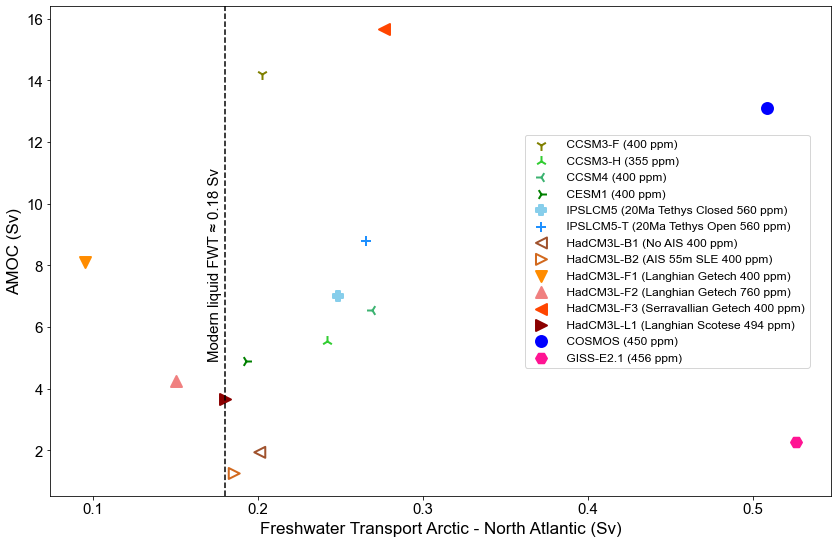

In [99]:
arctic_fwt=fwf['Arcitc_Atlantic_FW_export'].to_numpy()
amoc_mio=moc_strength['AMOC_Miocene'].to_numpy()
plt.figure(figsize=[14,9])
s=120
f=15
ms=10
for i in range(14):
    plt.scatter(arctic_fwt[i],amoc_mio[i],s=s,marker=markers[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=2.0,label=labels[i])   
plt.legend(fontsize=12, bbox_to_anchor=(0.6, 0.5))

plt.axvline(x=0.18, color='k', linestyle='--')
#plt.axhline(y=0.11, color='r', linestyle='--')
plt.xticks(fontsize=f)
plt.yticks(fontsize=f)

plt.annotate('Modern liquid FWT ≈ 0.18 Sv ',xy=(0.17,5),color="k",rotation=90,fontsize=f) # taken from Wang, H., Legg, S., & Hallberg, R. (2018). The Effect of Arctic Freshwater Pathways on North Atlantic Convection and the Atlantic Meridional Overturning Circulation. Journal of Climate, 31(13), 5165-5188. https://doi.org/https://doi.org/10.1175/JCLI-D-17-0629.1)

plt.xlabel('Freshwater Transport Arctic - North Atlantic (Sv)',fontsize=f+2)
plt.ylabel('AMOC (Sv)',fontsize=f+2)


### Figure 10 - Rocky mountains and Tibetan Plateau vs AMOC and PMOC 

In [38]:
rmtp

Simulations  Rockies_Height  Tibetan_Plateau_Height
0       CCSM3_F     1095.493896             3803.391113
1       CCSM3_H     1127.817627             4108.207520
2         CCSM4     1295.872681             4079.541992
3         CESM1     1295.872681             4079.541992
4       IPSLCM5     1979.542969             3549.704102
5     IPSLCM5_T     1979.542969             3549.704102
6    HadCM3L_B1     1862.784302             2340.815430
7   HadCM3L_B2      1862.784302             2340.815430
8    HadCM3L_F1     2117.980957             3903.210449
9    HadCM3L_F2     2117.980957             3903.210449
10   HadCM3L_F3     2120.688232             3940.667725
11   HadCM3L_L1     1411.019775             3429.868408
12       COSMOS     1039.696370             3018.389627
13         GISS     1345.374634             3736.392822

(2000.0, 4500.0)

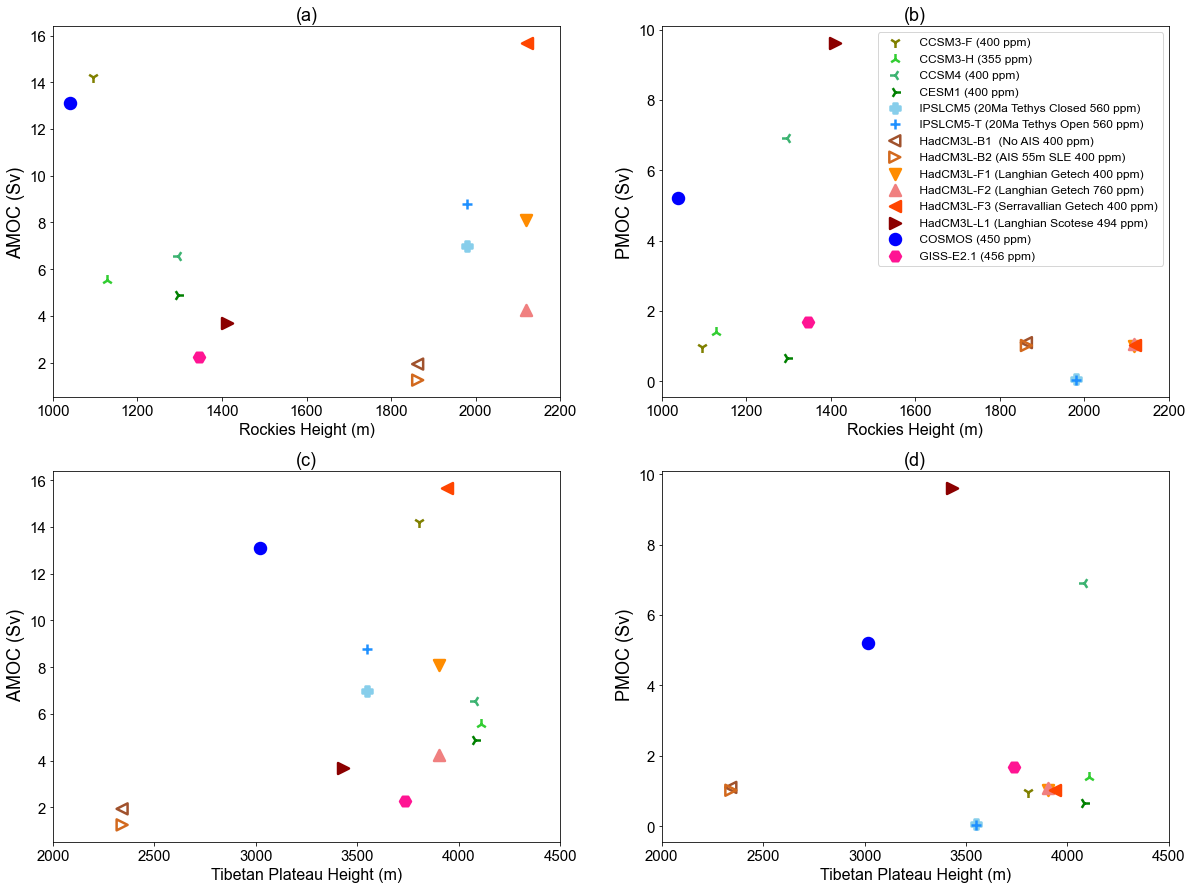

In [20]:
# MOC vs Rockies Height

rm=rmtp['Rockies_Height'].to_numpy()
tp=rmtp['Tibetan_Plateau_Height'].to_numpy()

s=120
f=18;f1=15
mlw=2.5
ll=1000;hl=2200
plt.figure(figsize=[20,15])

plt.subplot(221)

for i in range(14):
    plt.scatter(rm[i],amoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'Rockies Height (m)',fontsize=f-2)
plt.ylabel(r'AMOC (Sv)',fontsize=f)
#plt.legend()
plt.title('(a)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
#plt.ylim(0,16)
plt.xlim(ll,hl)

plt.subplot(222)

for i in range(14):
    plt.scatter(rm[i],pmoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'Rockies Height (m)',fontsize=f-2)
plt.ylabel(r'PMOC (Sv)',fontsize=f)
plt.title('(b)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
#plt.legend(fontsize=f1-2,bbox_to_anchor=(0.25, 0.32))
plt.xlim(ll,hl)
#plt.ylim(0,16)
plt.legend(fontsize=12)

plt.subplot(223)

for i in range(14):
    plt.scatter(tp[i],amoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'Tibetan Plateau Height (m)',fontsize=f-2)
plt.ylabel(r' AMOC (Sv)',fontsize=f)
#plt.legend()
plt.title('(c)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
#plt.ylim(0,16)
plt.xlim(2000,4500)

plt.subplot(224)

for i in range(14):
    plt.scatter(tp[i],pmoc_mio[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i])

plt.xlabel(r'Tibetan Plateau Height (m)',fontsize=f-2)
plt.ylabel(r' PMOC (Sv)',fontsize=f)
plt.title('(d)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
#plt.legend(fontsize=f1-2,bbox_to_anchor=(0.25, 0.32))
plt.xlim(2000,4500)
#plt.ylim(0,16)

#plt.savefig('Rockies_Tibetan_vs_AMOC_PMOC.pdf',dpi=300,bbox_inches='tight')


### Figure 11 - Zonal VT vs AMOC/PMOC

In [39]:
vt

Models  Panama Seaway VT  Tethys Seaway VT  Panama Seaway Depth
0       CCSM3_F          6.972000           -11.320           514.287781
1       CCSM3_H          0.600000           -11.270          3030.145264
2         CCSM4         -1.221000            -5.713          3751.891888
3         CESM1         -3.238000            -6.084          3751.891888
4       IPSLCM5          7.462000             0.000          1033.217285
5     IPSLCM5_T          3.661000            -3.724          1033.217285
6    HadCM3L_B1         11.171578             0.000           995.549988
7   HadCM3L_B2          11.468255             0.000           995.549988
8    HadCM3L_F1         12.581184             0.000           995.549988
9    HadCM3L_F2         12.397797             0.000           995.549988
10   HadCM3L_F3         12.650566             0.000           995.549988
11   HadCM3L_L1          7.191000             0.000          2731.449951
12       COSMOS         -8.049100            -7.540          3395.000000
13         GISS          2.130000            -2.520          1214.000000

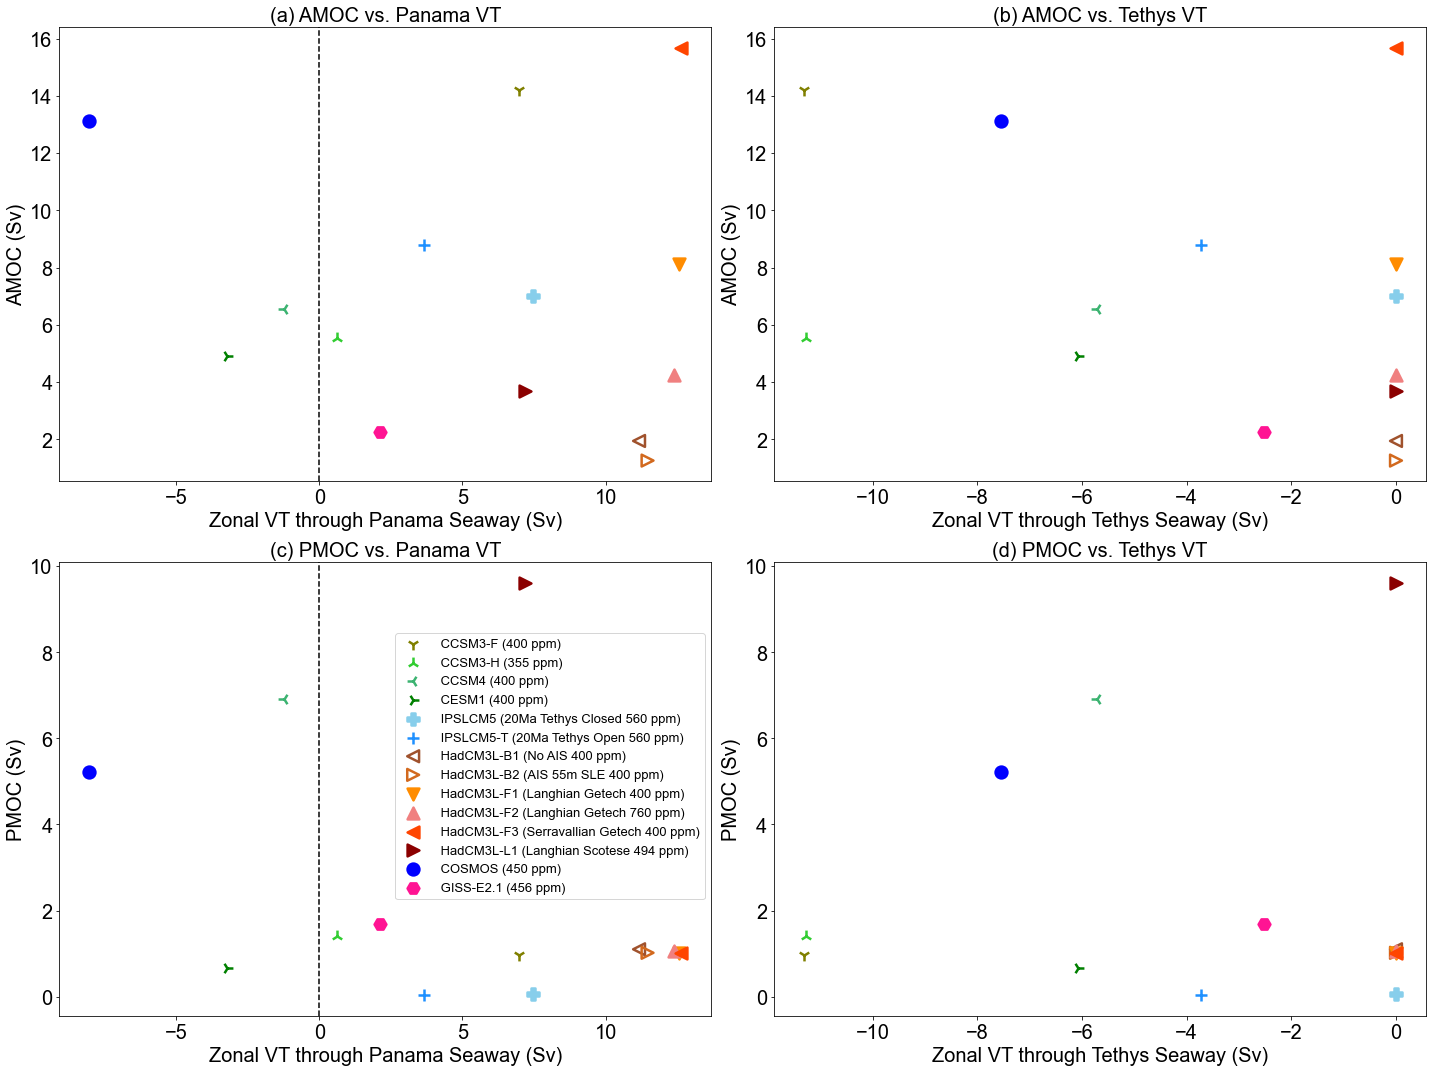

In [40]:
plt.figure(figsize=[20,15])
s=140
f=20
ms=10
fs_ticks=20
panama_vt=vt['Panama Seaway VT'].to_numpy()
tethys_vt=vt['Tethys Seaway VT'].to_numpy()


mlw=2.5


plt.subplot(221)
for i in range(14):
    plt.scatter(panama_vt[i],amoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)  
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Zonal VT through Panama Seaway (Sv)',fontsize=f)
plt.ylabel('AMOC (Sv)',fontsize=f)
#plt.legend(fontsize=12,loc=3)#bbox_to_anchor=(0.1, 0.4, 0.5, 0.5))
plt.title('(a) AMOC vs. Panama VT',fontsize=f)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)


plt.subplot(222)
for i in range(14):
    plt.scatter(tethys_vt[i],amoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)   

plt.xlabel('Zonal VT through Tethys Seaway (Sv)',fontsize=f)
plt.ylabel('AMOC (Sv)',fontsize=f)
#plt.legend()
plt.title('(b) AMOC vs. Tethys VT',fontsize=f)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)


plt.subplot(223)
for i in range(14):
    plt.scatter(panama_vt[i],pmoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)   
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Zonal VT through Panama Seaway (Sv)',fontsize=f)
plt.ylabel('PMOC (Sv)',fontsize=f)
plt.legend(fontsize=13,loc=7,bbox_to_anchor=(0.5, 0.3, 0.5, 0.5))
plt.title('(c) PMOC vs. Panama VT',fontsize=f)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)




plt.subplot(224)
for i in range(14):
    plt.scatter(tethys_vt[i],pmoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)   

plt.xlabel('Zonal VT through Tethys Seaway (Sv)',fontsize=f)
plt.ylabel('PMOC (Sv)',fontsize=f)
#plt.legend()
plt.title('(d) PMOC vs. Tethys VT',fontsize=f)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)

plt.tight_layout()


### Figure 12 - Age ranges of simulations 

In [24]:
ages

Simulations  Panama Seaway Age (Ma)   Tethys Seaway Age (Ma)  \
0       CCSM3_F                     9.00                   15.00   
1       CCSM3_H                    16.24                   14.25   
2         CCSM4                    14.73                   13.02   
3         CESM1                    14.73                   13.02   
4       IPSLCM5                     9.94                   13.00   
5     IPSLCM5_T                     9.94                   13.06   
6    HadCM3L_B1                    10.42                   13.00   
7   HadCM3L_B2                     10.42                   13.00   
8    HadCM3L_F1                    10.96                   13.00   
9    HadCM3L_F2                    10.96                   13.00   
10   HadCM3L_F3                    10.42                   13.00   
11   HadCM3L_L1                    15.33                   13.00   
12       COSMOS                    17.00                   14.36   
13         GISS                    10.12                   18.00   

    Fram Strait Age (Ma)  Target age Lower Lim (Ma)   \
0                  17.97                        14.5   
1                  18.20                        14.0   
2                  13.99                        14.0   
3                  13.99                        14.0   
4                  21.00                        20.0   
5                  21.00                        20.0   
6                  15.27                        11.6   
7                  15.27                        11.6   
8                  17.07                        13.8   
9                  17.07                        13.8   
10                 10.74                        11.6   
11                 10.74                        13.8   
12                 10.00                        14.0   
13                 10.97                        14.5   

    Target age Higher Lim (Ma)   Mean Target Age  \
0                          16.7            15.60   
1                          20.0            17.00   
2                          20.0            17.00   
3                          20.0            17.00   
4                          20.0            20.00   
5                          20.0            20.00   
6                          15.9            13.75   
7                          15.9            13.75   
8                          15.9            14.85   
9                          15.9            14.85   
10                         13.8            12.70   
11                         15.9            14.85   
12                         20.0            17.00   
13                         16.7            15.60   

    Mean Age Error (for error bars)  
0                              1.10  
1                              3.00  
2                              3.00  
3                              3.00  
4                              0.00  
5                              0.00  
6                              2.15  
7                              2.15  
8                              1.05  
9                              1.05  
10                             1.10  
11                             1.05  
12                             3.00  
13                             1.10

([<matplotlib.axis.YTick at 0x197b31250>,
 [Text(0, 13, ' CCSM3-F'),
  Text(0, 12, ' CCSM3-H'),
  Text(0, 11, ' CCSM4'),
  Text(0, 10, ' CESM1'),
  Text(0, 9, ' IPSLCM5'),
  Text(0, 8, ' IPSLCM5-T'),
  Text(0, 7, ' HadCM3L-B1'),
  Text(0, 6, ' HadCM3L-B2'),
  Text(0, 5, ' HadCM3L-F1'),
  Text(0, 4, ' HadCM3L-F2'),
  Text(0, 3, ' HadCM3L-F3'),
  Text(0, 2, ' HadCM3L-L1'),
  Text(0, 1, ' COSMOS'),
  Text(0, 0, ' GISS-E2.1')])

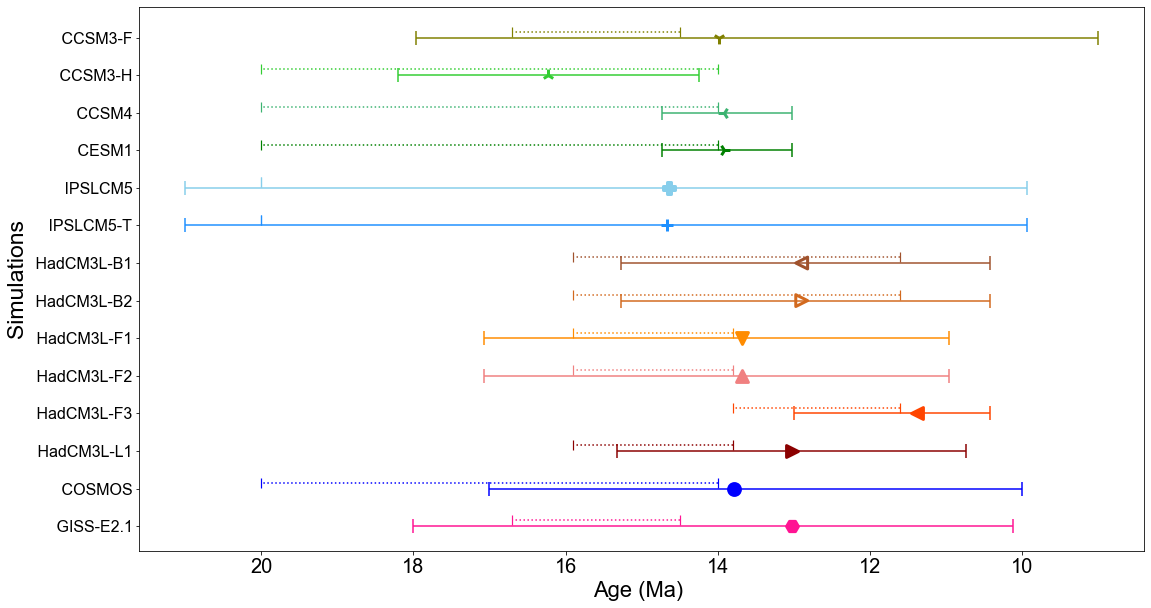

In [41]:
panama_age=ages['Panama Seaway Age (Ma) '].to_numpy()
tethys_age=ages['Tethys Seaway Age (Ma)'].to_numpy()
fram_age=ages['Fram Strait Age (Ma)'].to_numpy()


all_straits=np.vstack((panama_age,tethys_age,fram_age)).T
all_straits.sort(axis=1)
mean_straits=np.mean(all_straits,axis=1)
mean_target_age=ages['Mean Target Age'].to_numpy()
mean_target_err=ages['Mean Age Error (for error bars)'].to_numpy()

plt.figure(figsize=[18,10])
s=140
f=20
mlw=3
ls=np.ndarray(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)'])

labels=[' CCSM3-F (400 ppm)',' CCSM3-H (355 ppm)',' CCSM4 (400 ppm)',' CESM1 (400 ppm)',' IPSLCM5 (20Ma Tethys Closed 560 ppm)',
        ' IPSLCM5-T (20Ma Tethys Open 560 ppm)',' HadCM3L-B1 (No AIS 400 ppm)',' HadCM3L-B2 (AIS 55m SLE 400 ppm)',
        ' HadCM3L-F1 (Langhian Getech 400 ppm)',' HadCM3L-F2 (Langhian Getech 760 ppm)',' HadCM3L-F3 (Serravallian Getech 400 ppm)',
        ' HadCM3L-L1 (Langhian Scotese 494 ppm)',' COSMOS (450 ppm)',' GISS-E2.1 (456 ppm)']

labels1=[' CCSM3-F',' CCSM3-H',' CCSM4',' CESM1',' IPSLCM5',' IPSLCM5-T',' HadCM3L-B1',' HadCM3L-B2',' HadCM3L-F1',' HadCM3L-F2',
         ' HadCM3L-F3',' HadCM3L-L1',' COSMOS',' GISS-E2.1']
colors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','sienna','chocolate','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']

y_values = np.arange(13,-1,-1) # to use for plotting labels on Y axis


low=mean_straits-all_straits[:,0]
high=all_straits[:,2]-mean_straits
xerror=np.array([[low,high]]).T
ages1=np.array([panama_age,tethys_age,fram_age])
ages1_mean=np.mean(ages1,axis=0)
mean_age_psi=np.vstack((ages1_mean, amoc_mio)).T
mean_age_psi=mean_age_psi[mean_age_psi[:, 0].argsort()]
#plt.plot(mean_age_psi[:,0],mean_age_psi[:,1],'--',c='gray')
#mean_age_psi=mean_age_psi[mean_age_psi[:, 0].argsort()]
#plt.plot(ages1_mean,mean_age_psi[:,1],'--',c='gray')
for i in range(13,-1,-1):
    eb1=plt.errorbar(mean_straits[i], y_values[i], yerr=None, xerr=xerror[i],capsize=7,capthick=1.5,color=colors[i])
    eb2=plt.errorbar(mean_target_age[i], y_values[i]+0.15, yerr=None, xerr=mean_target_err[i],fmt='none',capsize=5,capthick=1.2,ecolor=colors[i])
    eb2[-1][0].set_linestyle(':')
    ages=[panama_age[i],tethys_age[i],fram_age[i]]
    plt.scatter(ages1_mean[i],y_values[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels[i],zorder=3)
#plt.legend(fontsize=17, bbox_to_anchor=(1, 0.8))   
plt.gca().invert_xaxis()
plt.xlabel(r'Age (Ma) ',fontsize=f+2)
plt.ylabel(r'Simulations',fontsize=f+3)
plt.xticks(fontsize=f)
plt.yticks(y_values, labels1, fontsize=f-4)
#plt.savefig('Age_Ranges.pdf', dpi=300,bbox_inches='tight')


In [54]:
combined_titles

['(a)  CCSM3-F',
 '(b)  CCSM3-H',
 '(c)  CCSM4',
 '(d)  CESM1',
 '(e)  IPSLCM5',
 '(f)  HadCM3L-B',
 '(g)  HadCM3L-F',
 '(h)  COSMOS',
 '(i)  GISS-E2.1']

# Supporting Information

## Figure S2 - MLD - Pre-Industrial 

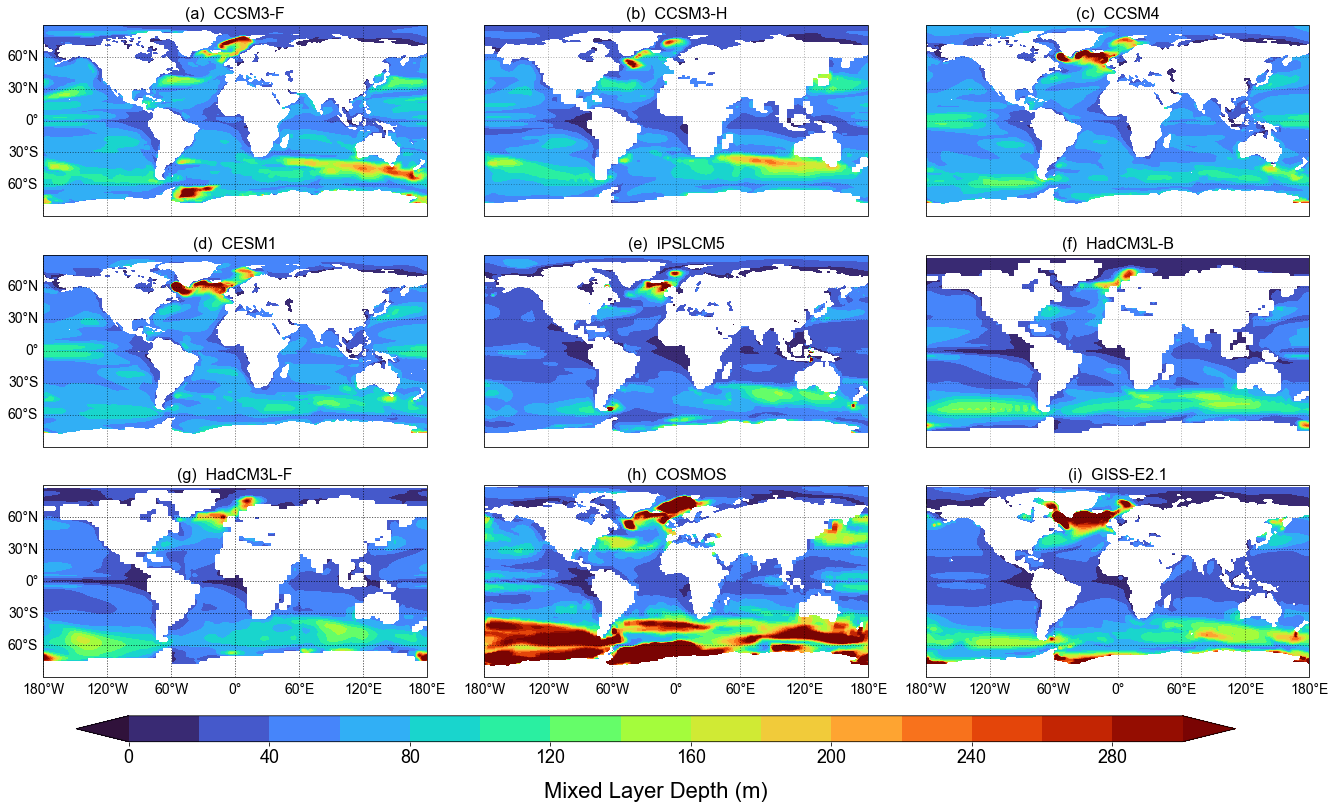

In [56]:
font='Arial'
plt.rc('font', family=font)
level=np.arange(0,320,20)
f=20;
projection=ccrs.PlateCarree(0)#Robinson(0)
cmap='turbo' #'Blues'#cmocean.cm.deep
facecolour='white';alpha=0.8
pad=10

mldi = mld_pi['MLD'] 
n_rows, n_cols = 3, 3

ls=np.array(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)'])

combined_titles = [f"{a1} {a2}" for a1, a2 in zip(ls, mld_pi.simulation.values)]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,12), subplot_kw={'projection': projection}, constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6] #panel plot number where left ticks should be added
bottom_ticks =[6,7,8] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(9):  # Adjust if the number of simulations changes
    ax = axes[i]
    sim_data = mldi.isel(sim=i)  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(sim_data.lon, sim_data.lat, sim_data, cmap=cmap, levels=level, transform=ccrs.PlateCarree(0), extend='both')
    contours.append(contour)

    # Add a title for each panel
    ax.set_title(combined_titles[i], fontsize=16)
    
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        gline(ax,b=False,l=True)     #b=bottom ticks; l=left ticks
    if i in bottom_ticks:
        gline(ax, b=True, l=False)
    gline(ax,b=False,l=False)        #adds grid lines to rest of the plots
    
    # Add labels for axes
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # Customize tick visibility
    
# Turn off unused subplots (if any)
for j in range(9, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('Mixed Layer Depth (m)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)

### Figure S3 - AMOC: Miocene - PI

Text(0.515, 0.92, 'Atlantic MOC (AMOC): Miocene - PI')

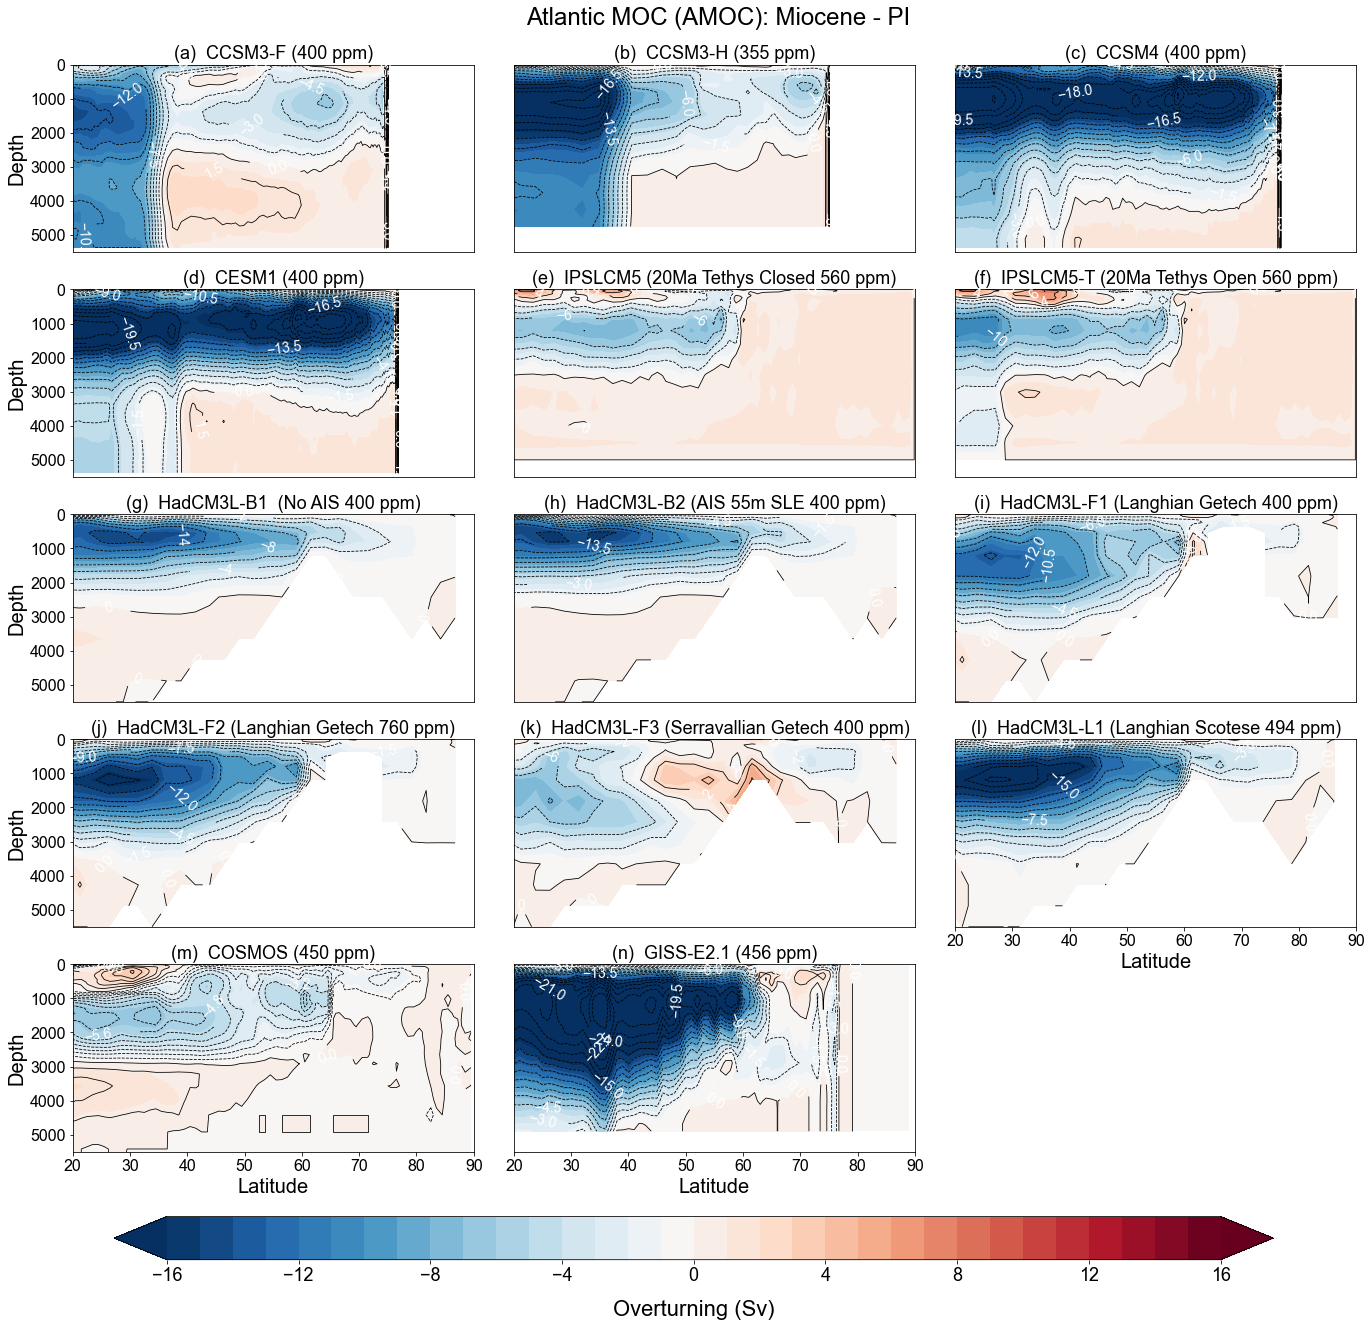

In [65]:
font='Arial'
plt.rc('font', family=font)
orig_cmap = matplotlib.cm.RdBu_r
f=20
f1=20
ts=16
cls=14 #contour label size
tl=6 #tick length
tw=2 #tick width
clev=25 #contour levels
m1=-16;m2=17;start=0.0;stop=1.0 #for shrunk_cmap
shrunk_cmap = shiftedColorMap1(orig_cmap, m1, m2,start,stop,'shrunk')
pad=10
ls=np.array(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)'])
combined_titles = [f"{a1} {a2}" for a1, a2 in zip(ls, mld.simulation.values)]

amoc_pi = [moc_ccsm3f.AMOC_pi, 
              moc_ccsm3h.AMOC_pi,
              moc_ccsm4.AMOC_pi,
              moc_cesm1.AMOC_pi,
              moc_ipsl.AMOC_pi,
              moc_ipslt.AMOC_pi,
              moc_hadcmb1.AMOC_pi,
              moc_hadcmb2.AMOC_pi,
              moc_hadcmf1.AMOC_pi,
              moc_hadcmf2.AMOC_pi,
              moc_hadcmf3.AMOC_pi,
              moc_hadcml1.AMOC_pi,
              moc_cosmos.AMOC_pi,
              moc_giss.AMOC_pi
       ]

amoc_mio_lat = [moc_ccsm3f.lat, 
              moc_ccsm3h.lat,
              moc_ccsm4.lat,
              moc_cesm1.lat,
              moc_ipsl.y,
              moc_ipslt.y,
              moc_hadcmb1.latitude,
              moc_hadcmb2.latitude,
              moc_hadcmf1.latitude,
              moc_hadcmf2.latitude,
              moc_hadcmf3.latitude,
              moc_hadcml1.latitude,
              moc_cosmos.lat,
              moc_giss.lat
       ]
amoc_mio_depth = [moc_ccsm3f.depth/100, 
              moc_ccsm3h.depth/100,
              moc_ccsm4.depth/100,
              moc_cesm1.depth/100,
              moc_ipsl.depthw,
              moc_ipslt.depthw,
              moc_hadcmb1.depth,
              moc_hadcmb2.depth,
              moc_hadcmf1.depth,
              moc_hadcmf2.depth,
              moc_hadcmf3.depth,
              moc_hadcml1.depth,
              moc_cosmos.lev,
              moc_giss.depth
       ]
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(23,20), constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  
    ax = axes[i]
    sim_data = amoc_mio[i]-amoc_pi[i]  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(amoc_mio_lat[i], amoc_mio_depth[i], sim_data, cmap=shrunk_cmap,levels=np.arange(m1,m2,1),extend='both')
    contours.append(contour)
    MOC1=ax.contour(amoc_mio_lat[i], amoc_mio_depth[i], sim_data,levels=clev, linewidths=0.8, colors='k')
    ax.clabel(MOC1, inline=1, fontsize=cls,colors='w',rightside_up=True)

    # Add a title for each panel
    ax.set_title(combined_titles[i], fontsize=18) # mld file contains names of simulations
    ax.axis([20,89.5,5500,0])
    #add gridlines and left and bottom ticks to certain panel plots to save space
    if i in left_ticks:
        ax.set_yticks(np.arange(5000, -1, -1000))

        ax.set_ylabel("Depth", fontsize=f1)
    else:
        ax.set_yticks([])
    if i in bottom_ticks:
        ax.set_xticks(np.arange(20, 91, 10))       #adds grid lines to rest of the plots
        ax.set_xlabel("Latitude", fontsize=f1) 
    else:
        ax.set_xticks([])
    # Add labels for axes
    
    ax.tick_params(labelsize=ts)
    
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.03],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('Overturning (Sv)',fontsize=22, labelpad=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('Atlantic MOC (AMOC): Miocene - PI',x=0.515,y=0.92, fontsize=24)

#plt.savefig('Miocene_AMOC.png',dpi=300,bbox_inches='tight', transparent=False)

### Figure S4 - Surface FWF - PI

### Figure S4 - Atlanitc-Pacific Surface FWF vs AMOC-PMOC : PI

In [67]:
moc_strength

Simulations  AMOC_Miocene    AMOC_PI  PMOC_Miocene   PMOC_PI  \
0       CCSM3_F     14.210000  16.020000      0.970000  3.830000   
1       CCSM3_H      5.550000  15.125931      1.410610  4.975703   
2         CCSM4      6.550000  24.488998      6.913148  1.443591   
3         CESM1      4.900000  24.287232      0.666028  1.742230   
4       IPSLCM5      6.991843  11.139221      0.055876  1.700836   
5     IPSLCM5_T      8.787570  11.139221      0.036233  1.700836   
6    HadCM3L_B1      1.940160  16.273062      1.101752  0.383954   
7   HadCM3L_B2       1.254420  16.273062      1.020240  0.383954   
8    HadCM3L_F1      8.109295  19.441463      1.020111  0.861318   
9    HadCM3L_F2      4.261272  19.441463      1.073292  0.861318   
10   HadCM3L_F3     15.672021  19.441463      1.021690  0.861318   
11   HadCM3L_L1      3.683608  19.441463      9.615513  0.861318   
12       COSMOS     13.110000  16.000000      5.214844  1.570000   
13         GISS      2.260000  24.240000      1.690000  0.640000   

    SOMOC_Miocene   SOMOC_PI  
0          -27.90 -21.510000  
1          -17.80 -14.993000  
2          -13.00  -8.460544  
3           -6.00  -5.568787  
4          -16.60 -16.123137  
5          -14.60 -16.123137  
6          -11.10 -16.693449  
7          -13.00 -16.693449  
8          -17.50 -20.327190  
9          -18.70 -20.327190  
10         -19.70 -20.327190  
11         -23.10 -20.327190  
12          -3.30  -8.660000  
13         -26.71 -10.980000

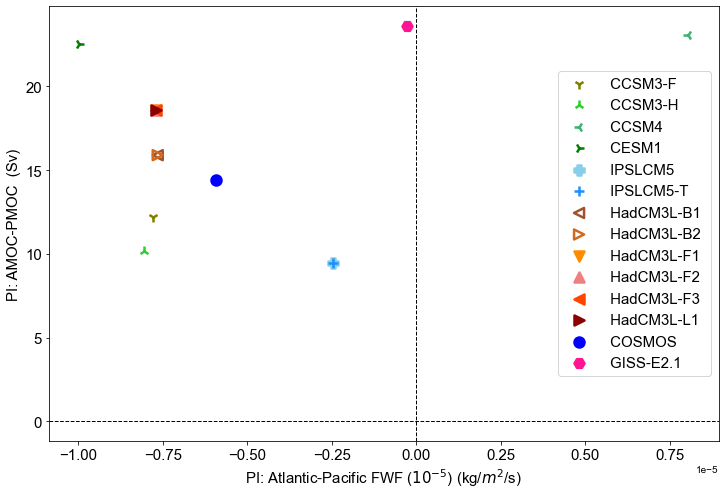

In [72]:
f1=15
amoc_mio = moc_strength['AMOC_Miocene'].to_numpy()
amoc_pi = moc_strength['AMOC_PI'].to_numpy()
pmoc_mio = moc_strength['PMOC_Miocene'].to_numpy()
pmoc_pi = moc_strength['PMOC_PI'].to_numpy()

del_flux_pi=fwf['Atlantic_Surface_FWF_PI'].to_numpy()-fwf['Pacific_Surface_FWF_PI'].to_numpy()

del_moc_pi=amoc_pi-pmoc_pi
s=100
mlw=2.5 #marker line width
f=15
bbox = dict(boxstyle="round", fc="0.9")
plt.figure(figsize=[12,8])


for i in range(14):
#    if (i!=1 or i!=8 or i!=9):
    plt.scatter(del_flux_pi[i],del_moc_pi[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels1[i])

plt.xlabel(r'PI: Atlantic-Pacific FWF ($10^{-5}$) (kg/$m^{2}$/s)',fontsize=f)
plt.ylabel(r'PI: AMOC-PMOC  (Sv)',fontsize=f)

plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.legend(fontsize=f1)
#plt.savefig('FWflux_vs_MOC_PI.pdf',dpi=300,bbox_inches='tight')



## Figure S5

In [42]:
salinity

Simulations  NA_Salinity_500  NP_Salinity_500  NA_Salinity_surface  \
0       CCSM3_F        36.100708        35.181110            32.783215   
1       CCSM3_H        34.981905        34.800000            30.118030   
2         CCSM4        35.564671        35.460000            29.996266   
3         CESM1        35.687008        34.430000            31.127412   
4       IPSLCM5        36.119016        34.919826            32.553034   
5     IPSLCM5_T        36.097624        34.960045            31.506735   
6    HadCM3L_B1        35.145773        35.188506            29.292253   
7   HadCM3L_B2         35.212667        35.378029            29.514460   
8    HadCM3L_F1        35.663686        34.323625            32.263755   
9    HadCM3L_F2        35.585932        34.185697            31.087970   
10   HadCM3L_F3        35.884295        34.354378            33.480525   
11   HadCM3L_L1        35.718786        35.350389            31.763823   
12       COSMOS        36.608337        34.188977            32.421267   
13         GISS        35.700000        35.570000            32.404566   

    NP_Salinity_surface  
0             32.669167  
1             31.619568  
2             35.120374  
3             32.914522  
4             32.320727  
5             32.250670  
6             31.806852  
7             32.005170  
8             32.386215  
9             31.880225  
10            32.523839  
11            34.247195  
12            32.427487  
13            33.144766

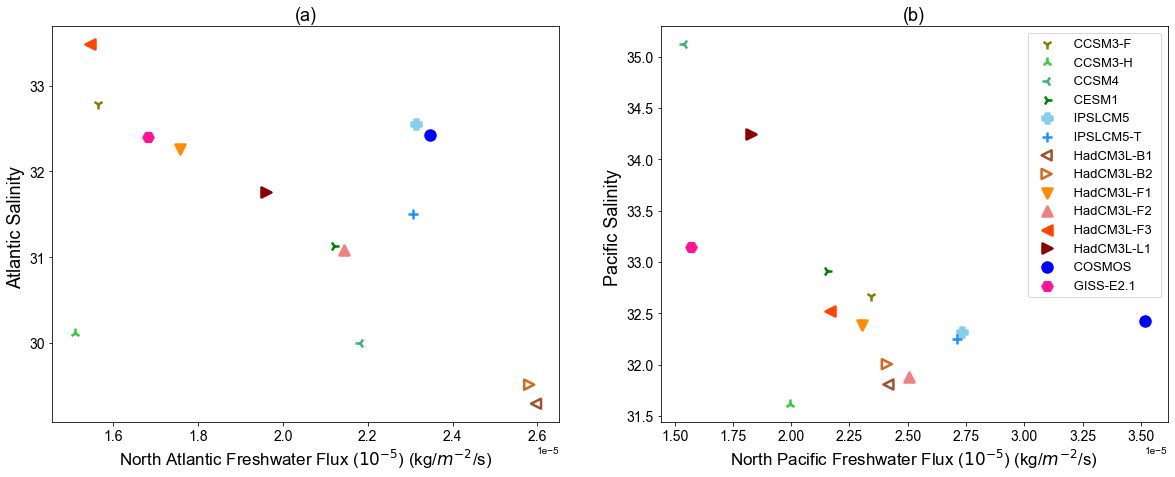

In [43]:
s=100
f=18;f1=14
mlw=2.5
labels=[' CCSM3-F (400 ppm)',' CCSM3-H (355 ppm)',' CCSM4 (400 ppm)',' CESM1 (400 ppm)',' IPSLCM5 (20Ma Tethys Closed 560 ppm)',
        ' IPSLCM5-T (20Ma Tethys Open 560 ppm)',' HadCM3L-B1 (No AIS 400 ppm)',' HadCM3L-B2 (AIS 55m SLE 400 ppm)',
        ' HadCM3L-F1 (Langhian Getech 400 ppm)',' HadCM3L-F2 (Langhian Getech 760 ppm)',' HadCM3L-F3 (Serravallian Getech 400 ppm)',
        ' HadCM3L-L1 (Langhian Scotese 494 ppm)',' COSMOS (450 ppm)',' GISS-E2.1 (456 ppm)']
labels1=[' CCSM3-F ',' CCSM3-H ',' CCSM4 ',' CESM1 ',' IPSLCM5 ',' IPSLCM5-T ',' HadCM3L-B1 ',' HadCM3L-B2 ',' HadCM3L-F1 ',
         ' HadCM3L-F2 ',' HadCM3L-F3 ',' HadCM3L-L1 ',' COSMOS ',' GISS-E2.1 ']

markers=['1','2','3','4','P','+','<','>','v','^','<','>','o','H']
edgecolors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','sienna','chocolate','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']
facecolors=['olive','limegreen','mediumseagreen','green','skyblue','dodgerblue','none','none','darkorange','lightcoral','orangered','darkred','blue', 'deeppink']

atl_sal=salinity['NA_Salinity_surface'].to_numpy()
pac_sal=salinity['NP_Salinity_surface'].to_numpy()

plt.figure(figsize=[20,16])


plt.subplot(221)

for i in range(14):
    plt.scatter(fwf_atl[i],atl_sal[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels1[i])

plt.xlabel(r'North Atlantic Freshwater Flux ($10^{-5}$) (kg/$m^{-2}$/s)',fontsize=f-1)
plt.ylabel(r'Atlantic Salinity ',fontsize=f)
plt.title('(a)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
#plt.xlim(1.2e-5,3.7e-5)
#plt.ylim(33,36)

plt.subplot(222)

for i in range(14):
#    if(i!=1):
    plt.scatter(fwf_pac[i],pac_sal[i],s=s,facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw,marker=markers[i],label=labels1[i])

plt.xlabel(r'North Pacific Freshwater Flux ($10^{-5}$) (kg/$m^{-2}$/s)',fontsize=f-1)
plt.ylabel(r'Pacific Salinity ',fontsize=f)
plt.title('(b)',fontsize=f)
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.legend(fontsize=f-5)
#plt.xlim(1.2e-5,3.7e-5)
#plt.ylim(33,36)
#plt.savefig('FWflux_vs_MOC_salinity.png',dpi=300,bbox_inches='tight')


bbox = dict(boxstyle="round", fc="0.9")


### Figure S6 - Arctic Sea surface Salinity (Miocene)

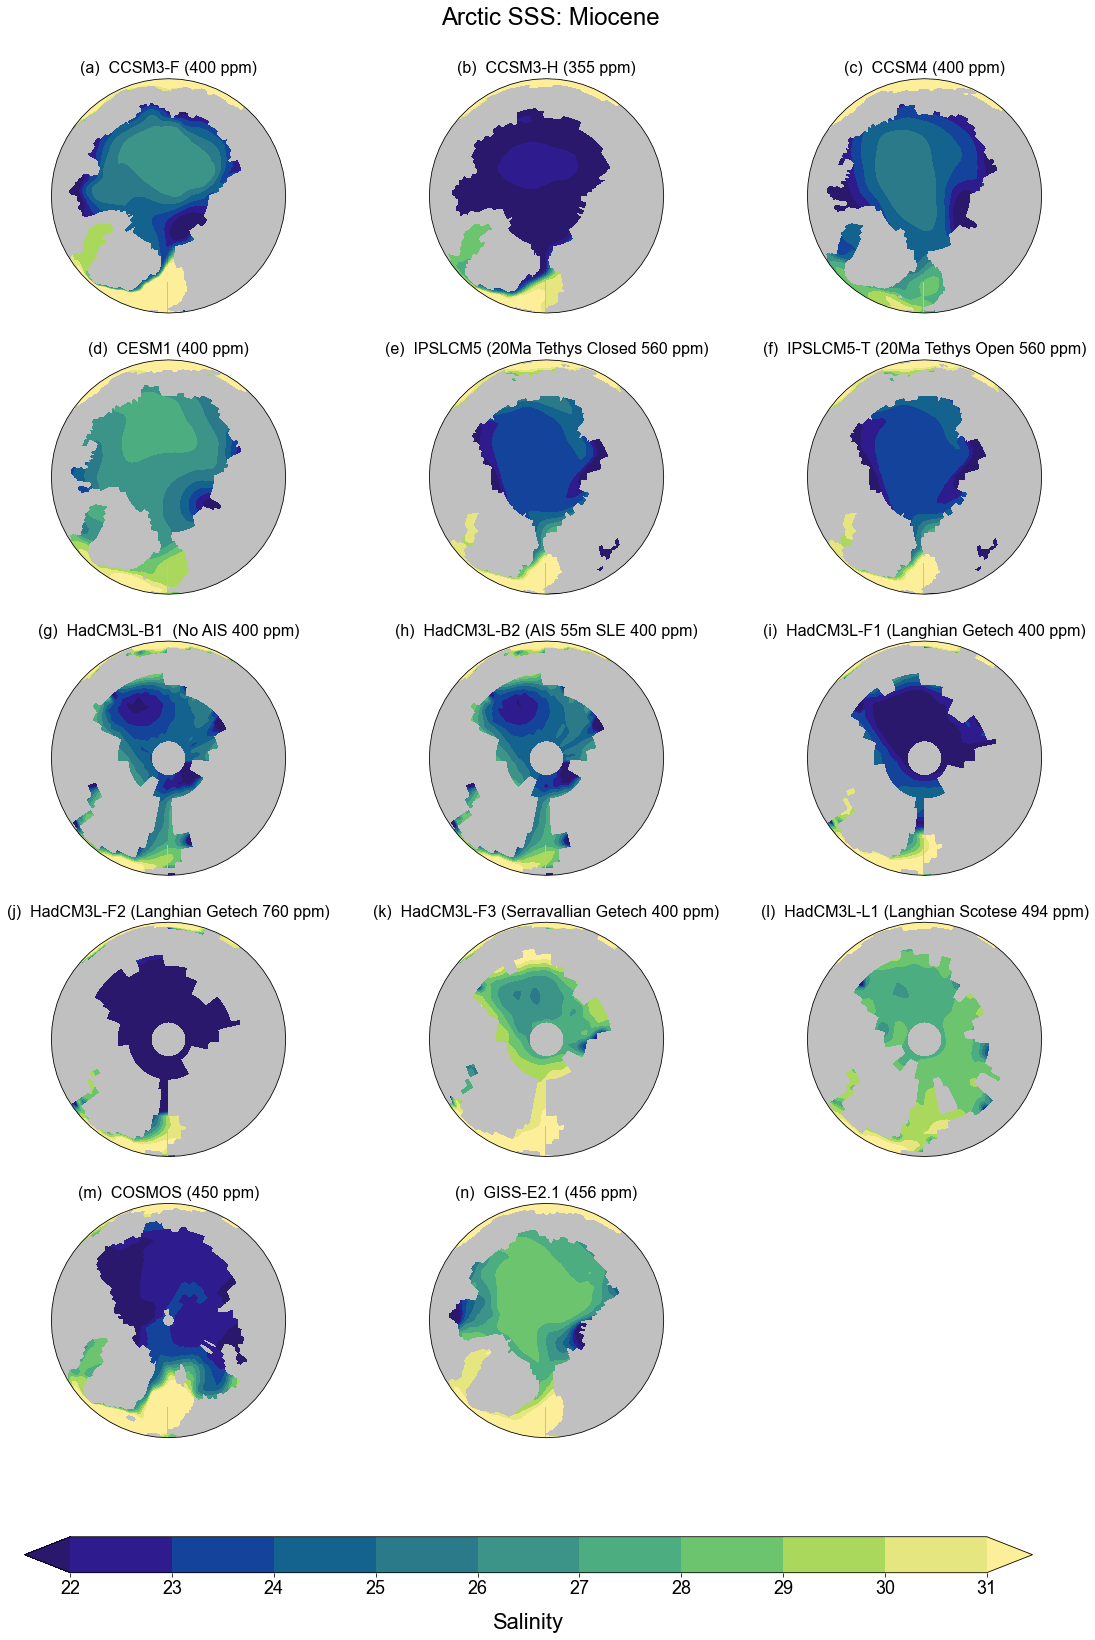

In [82]:
font='Arial'
plt.rc('font', family=font)
level=np.arange(22,32,1)
f=20;
projection = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=90.0, satellite_height=1785831, false_easting=0, false_northing=0, globe=None)

cmap='cmo.haline' #'Blues'#cmocean.cm.deep
facecolour='silver'
alpha=0.8
pad=10
ls=np.array(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)'])
combined_titles = [f"{a1} {a2}" for a1, a2 in zip(ls, mld.simulation.values)]
cmap = plt.get_cmap(cmap).copy()  # Get and copy the colormap
cmap.set_bad(color='silver')      # Set color for NaN values

sss_plot = sss['SSS'] 
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,25), subplot_kw={'projection': projection}, constrained_layout=True)
# Flatten the axes array for easier iteration
axes = axes.flatten()
# Create a list to hold the contour objects for the shared colorbar
contours = []

left_ticks=[0,3,6,9,12] #panel plot number where left ticks should be added
bottom_ticks =[11,12,13] #panel plot number where bottom ticks should be added

# Loop through each simulation
for i in range(14):  # Adjust if the number of simulations changes
    ax = axes[i]
    sim_data = sss_plot.isel(sim=i)  # Select the i-th simulation

    # Create a filled contour plot and store it in the contours list
    contour = ax.contourf(sim_data.lon, sim_data.lat, sim_data, cmap=cmap, levels=level,transform=ccrs.PlateCarree(0), extend='both')
    contours.append(contour)

    # Add a title for each panel
    ax.set_title(combined_titles[i], fontsize=16)
    ax.set_facecolor(facecolour)

    # #add gridlines and left and bottom ticks to certain panel plots to save space
    # if i in left_ticks:
    #     gline(ax,b=False,l=True)     #b=bottom ticks; l=left ticks
    # if i in bottom_ticks:
    #     gline(ax, b=True, l=False)
    # gline(ax,b=False,l=False)        #adds grid lines to rest of the plots
    
    # Add labels for axes
    # ax.set_xlabel("Longitude")
    # ax.set_ylabel("Latitude")
    # Customize tick visibility
    
# Turn off unused subplots (if any)
for j in range(14, n_rows * n_cols):  # Start after the 14th simulation
    axes[j].axis("off")

# Add a single colorbar at the bottom of the figure
# Use the last contour object to extract the color mapping
cbar2_ax = fig.add_axes([ 0.15,0.05, 0.7, 0.02],)
cbar1 = fig.colorbar(contours[-1], cax=cbar2_ax,extend='both',orientation='horizontal')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('Salinity',fontsize=22, labelpad=15)

fig.suptitle('Arctic SSS: Miocene',x=0.515,y=0.92, fontsize=24)

plt.subplots_adjust(wspace=0.05, hspace=0.2)

### Figure S7 - Panama Depth vs AMOC/PMOC - Miocene

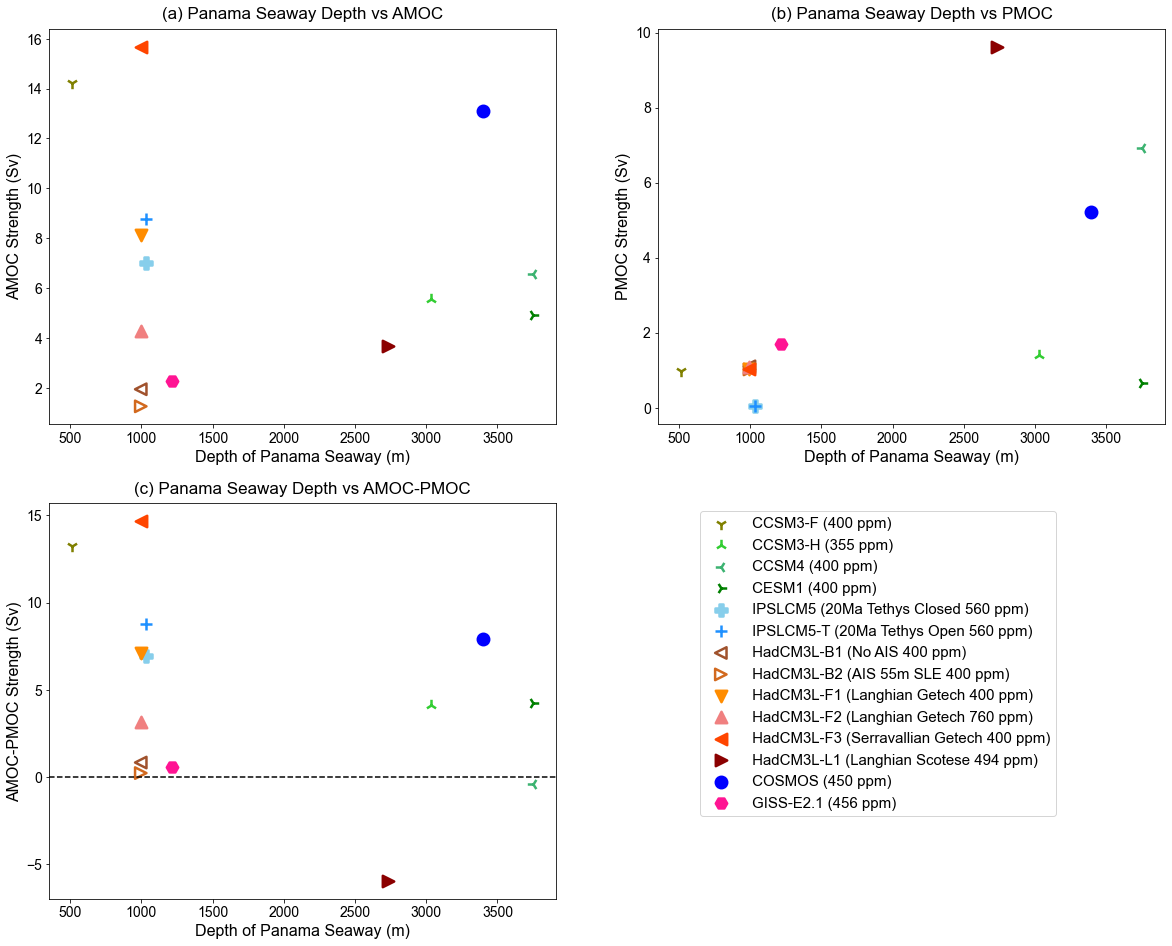

In [85]:
## Panama Depth vs AMOC
dep_panama=vt['Panama Seaway Depth'].to_numpy()
amoc_mio=moc_strength['AMOC_Miocene'].to_numpy()
pmoc_mio=moc_strength['PMOC_Miocene'].to_numpy()

plt.figure(figsize=[20,16])
s=130
f=16
ms=10
f1=14
f2=17


plt.subplot(221)
style='steps-mid'
for i in range(14):
    plt.scatter(dep_panama[i],amoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)   


plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)

plt.title('(a) Panama Seaway Depth vs AMOC',fontsize=f2, pad=10)
#plt.gca().invert_yaxis()
#plt.legend(fontsize=14)
plt.ylabel('AMOC Strength (Sv)',fontsize=f)
plt.xlabel('Depth of Panama Seaway (m)',fontsize=f)

plt.subplot(222)
for i in range(14):
    plt.scatter(dep_panama[i],pmoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)   

plt.xlabel('Depth of Panama Seaway (m)',fontsize=f)
plt.ylabel('PMOC Strength (Sv)',fontsize=f)

plt.title('(b) Panama Seaway Depth vs PMOC',fontsize=f2, pad=10)
#plt.axhline(y=0, color='k', linestyle='--')

plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)

plt.subplot(223)
for i in range(14):
    plt.scatter(dep_panama[i],amoc_mio[i]-pmoc_mio[i],s=s,marker=markers[i],label=labels[i],facecolors=facecolors[i],edgecolors=edgecolors[i], linewidths=mlw)   

plt.xlabel('Depth of Panama Seaway (m)',fontsize=f)
plt.ylabel('AMOC-PMOC Strength (Sv)',fontsize=f)
#plt.legend(fontsize=15)
plt.title('(c) Panama Seaway Depth vs AMOC-PMOC',fontsize=f2, pad=10)
#plt.axhline(y=0, color='k', linestyle='--')
plt.legend(fontsize=15, bbox_to_anchor=(2.0, 1))
plt.xticks(fontsize=f1)
plt.yticks(fontsize=f1)
plt.axhline(y=0, ls='--', c='k')
#plt.tight_layout()

#plt.savefig('pan_dep_vs_amoc_pmoc_Manuscript_300.pdf', dpi=250,bbox_inches='tight')
